# Prediction of Loan Default

## **<font color='blue'>Project Description**

### Objective

__The objective of the final project will be to build a fully reproducible project that uses ML to address a question of your choice (e.g. in academic or industry).The dataset required for this project is provided along with this document (see details below). This is an individual project. Since this course is an advanced undergraduate/graduate student level course, it is expected that the final report should be publishable and fully reproducible.__

### Dataset

__Domain:__ Banking

__Context:__ This data set contains historical data of the customers who have taken loans from a German bank and the bank is facing issues with loan defaulters. The bank intends to build a machine learning model to predict whether the customer will default or not based on historical data

__Dataset__ - German_bank.csv

__Data Description:__ The bank has historical information on relevant features for each customer such as employment duration, existing loans count, saving balance, percentage of income, age, default status. 

The data set has 17 columns and 1000 rows. Columns are described below and each row is a customer. 

   - checking_balance - Amount of money available in account of customers
   - months_loan_duration - Duration since loan taken
   - credit_history - credit history of each customers
   - purpose - Purpose why loan has been taken
   - amount - Amount of loan taken
   - savings_balance - Balance in account
   - employment_duration - Duration of employment
   - percent_of_income - Percentage of monthly income
   - years_at_residence - Duration of current residence
   - age - Age of customer
   - other_credit - Any other credits taken
   - housing- Type of housing, rent or own
   - existing_loans_count - Existing count of loans
   - job - Job type
   - dependents - Any dependents on customer
   - phone - Having phone or not
   - default - Default status (Target column)


### Libraries and Functions

#### Importing libraries

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
if not os.path.exists('submission'):
    os.makedirs('submission', 0o777)

from fpdf import FPDF
import math
# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)
# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    KFold, 
    cross_val_score, 
    cross_validate , 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    r2_score,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
    zero_one_loss,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
    VotingClassifier
)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


#### Functions

In [378]:
def results_(model, target, predictor, name):
    pred = model.predict(predictor)
    accuracy_ = accuracy_score(target, pred)
    recal = recall_score(target, pred) 
    preci = precision_score(target, pred)
    zero_1_loss_ = zero_one_loss(target, pred)
    auc = roc_auc_score(target, pred) 
    f1 = f1_score(target, pred)
    
    report_ = classification_report(target, pred)
    CM = confusion_matrix(target, pred)
    
    metrics = pd.DataFrame({"Accuracy":accuracy_ , "Recall": recal, "Precision": preci,"f1": f1,
                            "zero_1_loss_":zero_1_loss_, "AUC":auc}, index = [name])
    return metrics, report_ ,CM

##################################################################################################################
##################################################################################################################
def classifiers_result_compar(models_, Xtrain, Ytrain, Xtest, Ytest):
    models_compar_ = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision'])
    models_results_ = {}
    for name, model in models_:
        model_ = model.fit(Xtrain , Ytrain)
        model_train, report_train, CM_train = results_(model_, Ytrain, Xtrain, f"{name} train")
        model_test , report_test , CM_test  = results_(model_, Ytest, Xtest,  f"{name} test")
        ##
        if name != 'SVC':
            pred_proba = model.predict_proba(Xtest)[::,1]
        else:
            pred_proba = model.decision_function(Xtest)
        ##   
        fpr, tpr, _ = roc_curve(Ytest,  pred_proba)
        auc = roc_auc_score(Ytest, pred_proba)    
        ##      
        models_results_[name] =  {'model':model, 'train':{'report':report_train, 'confus_matrix':CM_train},
                                     'test':{'report':report_test, 'confus_matrix':CM_test},
                               'roc_fpr_tpr': {'fpr':fpr, 'tpr': tpr, 'auc':auc}}
        models_compar_ = pd.concat([models_compar_, model_train, model_test])
        
    return models_results_, models_compar_.T

##################################################################################################################
##################################################################################################################
def plot_ROC(models_resuls):
    plt.figure(figsize=(9, 9)) 
    for n in models_resuls.keys():
        plt.plot(models_resuls[n]['roc_fpr_tpr']['fpr'], models_resuls[n]['roc_fpr_tpr']['tpr'], label=n)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('ROC')
    plt.legend(loc='lower right')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])
      

##################################################################################################################
##################################################################################################################
def fit_tunned_model(model, name):
    model = model.fit(x_train , y_train)
    train, report_train, CM_train = results_(model, y_train, x_train, f"{name} train")
    test , report_test , CM_test  = results_(model, y_test, x_test,  f"{name} test")
    
    return pd.concat([train,test])
##################################################################################################################
##################################################################################################################
def fit_tunned_model_2(model, name):
    model = model.fit(X_train , Y_train)
    train, report_train, CM_train = results_(model, Y_train, X_train, f"{name} train")
    test , report_test , CM_test  = results_(model, y_test, x_test,  f"{name} test")
    
    return pd.concat([train,test])

## EDA

### Loading and Clean Data

In [5]:
data_german_bank = pd.read_csv("German_bank.csv")
data_german_bank.sample(5)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
115,unknown,48,critical,furniture/appliances,3578,unknown,> 7 years,4,1,47,none,own,1,skilled,1,yes,no
939,unknown,24,critical,car,6842,unknown,1 - 4 years,2,4,46,none,own,2,management,2,yes,no
287,1 - 200 DM,48,poor,car0,7582,100 - 500 DM,unemployed,2,4,31,none,other,1,management,1,yes,no
210,unknown,9,critical,furniture/appliances,3074,unknown,1 - 4 years,1,2,33,none,own,2,skilled,2,no,no
830,unknown,24,poor,business,2375,500 - 1000 DM,1 - 4 years,4,2,44,none,own,2,skilled,2,yes,no


In [6]:
data_german_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

In [7]:
data_german_bank.duplicated().sum()

0

In [8]:
lst =[]
for col , d_type in data_german_bank.dtypes.items():
    if data_german_bank[col].dtype == object:
        uniqu_ = data_german_bank[col].value_counts()
        lst.append(pd.DataFrame({'category': uniqu_.index, 'count': uniqu_.values}, index=[col]*len(uniqu_)))
        
pd.concat(lst)

,category,count
checking_balance,unknown,394
checking_balance,< 0 DM,274
checking_balance,1 - 200 DM,269
checking_balance,> 200 DM,63
credit_history,good,530
credit_history,critical,293
credit_history,poor,88
credit_history,very good,49
credit_history,perfect,40
purpose,furniture/appliances,473


In [9]:
data_german_bank.describe().T

,count,mean,std,min,25%,50%,75%,max
months_loan_duration,1000.000,20.903,12.059,4.000,12.000,18.000,24.000,72.000
amount,1000.000,3271.258,2822.737,250.000,1365.500,2319.500,3972.250,18424.000
percent_of_income,1000.000,2.973,1.119,1.000,2.000,3.000,4.000,4.000
years_at_residence,1000.000,2.845,1.104,1.000,2.000,3.000,4.000,4.000
age,1000.000,35.546,11.375,19.000,27.000,33.000,42.000,75.000
existing_loans_count,1000.000,1.407,0.578,1.000,1.000,1.000,2.000,4.000
dependents,1000.000,1.155,0.362,1.000,1.000,1.000,1.000,2.000


In [10]:
data_german_bank.iloc[data_german_bank.amount.sort_values(ascending=False).index].head(10)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
915,1 - 200 DM,48,perfect,car0,18424,< 100 DM,1 - 4 years,1,2,32,bank,own,1,management,1,yes,yes
95,1 - 200 DM,54,perfect,business,15945,< 100 DM,< 1 year,3,4,58,none,rent,1,skilled,1,yes,yes
818,< 0 DM,36,good,car0,15857,< 100 DM,unemployed,2,3,43,none,own,1,management,1,no,no
887,1 - 200 DM,48,good,business,15672,< 100 DM,1 - 4 years,2,2,23,none,own,1,skilled,1,yes,yes
637,unknown,60,poor,furniture/appliances,15653,< 100 DM,4 - 7 years,2,4,21,none,own,2,skilled,1,yes,no
917,< 0 DM,6,good,car,14896,< 100 DM,> 7 years,1,4,68,bank,own,1,management,1,yes,yes
374,1 - 200 DM,60,very good,car0,14782,100 - 500 DM,> 7 years,3,4,60,bank,other,2,management,1,yes,yes
236,1 - 200 DM,6,good,car,14555,unknown,unemployed,1,2,23,none,own,1,unemployed,1,yes,yes
63,1 - 200 DM,48,perfect,business,14421,< 100 DM,1 - 4 years,2,2,25,none,own,1,skilled,1,yes,yes
378,1 - 200 DM,36,good,car,14318,< 100 DM,> 7 years,4,2,57,none,other,1,management,1,yes,yes



__There is no missing data, or duplication in rows.__




__The target is the 'default' column, and it has two values 'yes' and 'no'.__


__The rest 16 columns has 7 numarical.__

   - months_loan_duration, amount, percent_of_income, years_at_residence, age, existing_loans_count, and dependents.
   
__And 9 are categorical:__

   - checking_balance: it seems ordinal, but it has value 'unknown', that why we will treat it as nominal. Same for savings_balance, and job.
   
   
__Nominal columns are:__

   - checking_balance, purpose, savings_balance, other_credit, housing, job, and phone.
   
   
__Ordinal:__

   - credit_history and employment_duration

### Features Distribution and Relationships

#### Distribution of Target

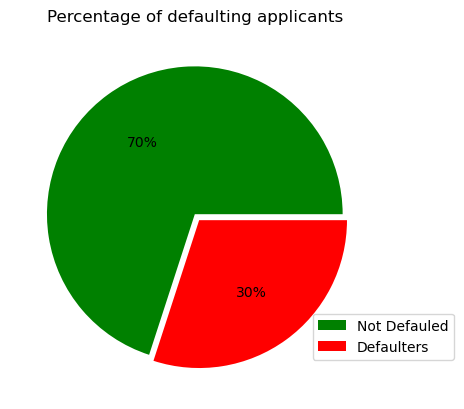

In [171]:
## Pie chart to show target classes percentage
sns.set_palette('bright')

plt.pie(data_german_bank.default.value_counts(), colors=['g','r'],
        explode=[0, 0.05], autopct='%.0f%%');
plt.legend( labels=['Not Defauled','Defaulters'],  bbox_to_anchor=(0.8, 0.25))
## To save image to be used later in final report
## dpi to save good image resolution
plt.savefig(f"./submission/Percentage_of_defaulting_applicants.png", dpi=300)
## Title after save becuse i will add title at the pdf final report
plt.title('Percentage of defaulting applicants');

$30$% of the lenders defaulted, This is imbalanced classies

#### Univariate Analysis

##### Numarical Features

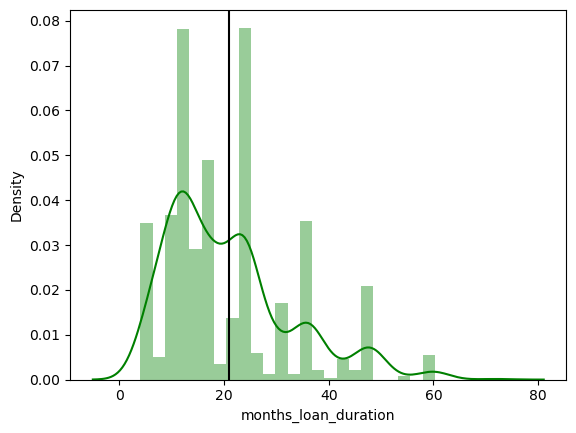

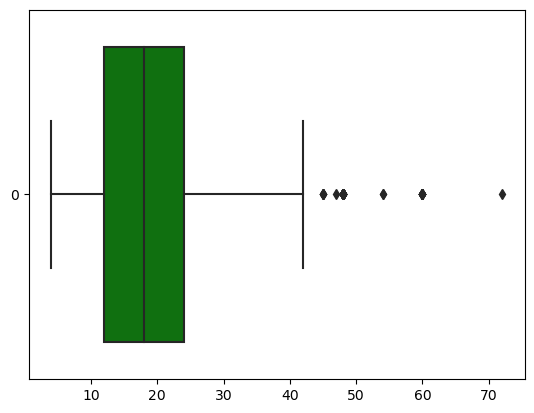

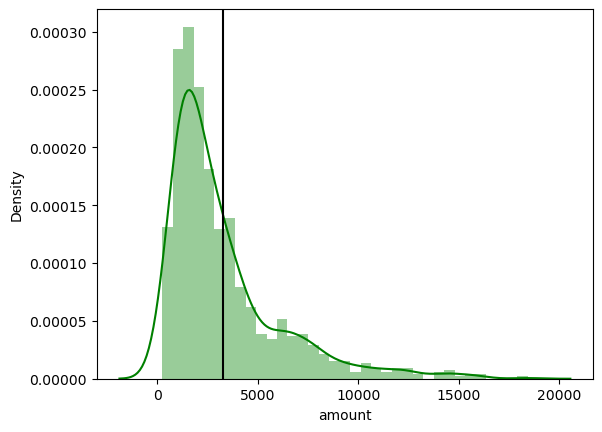

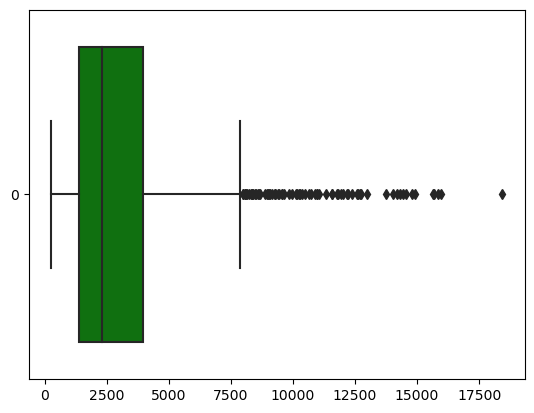

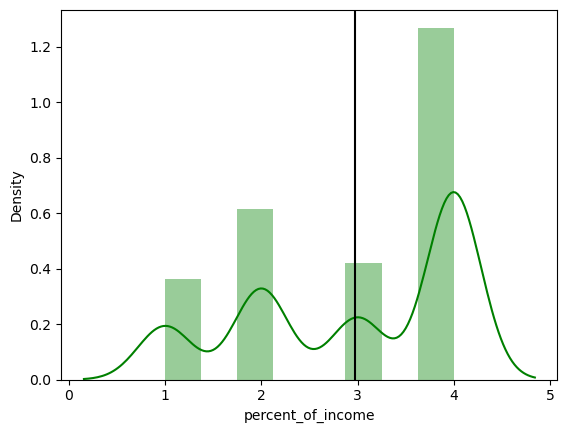

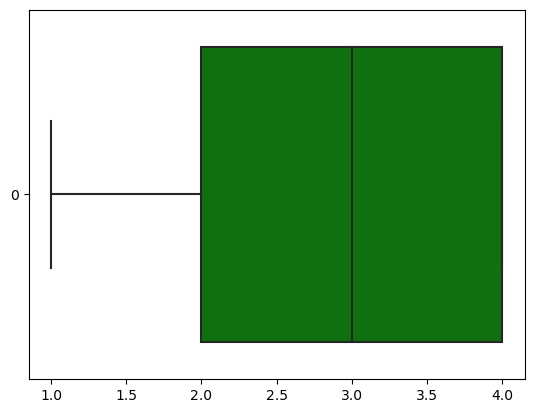

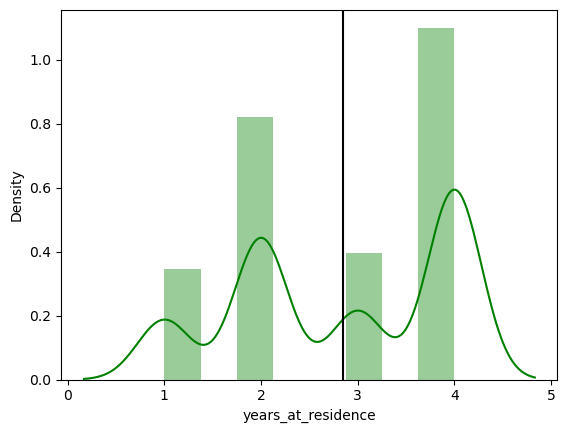

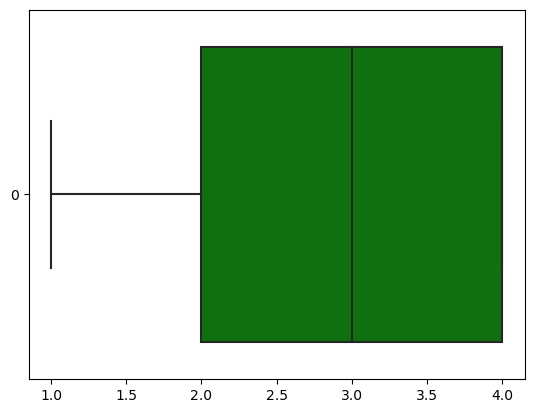

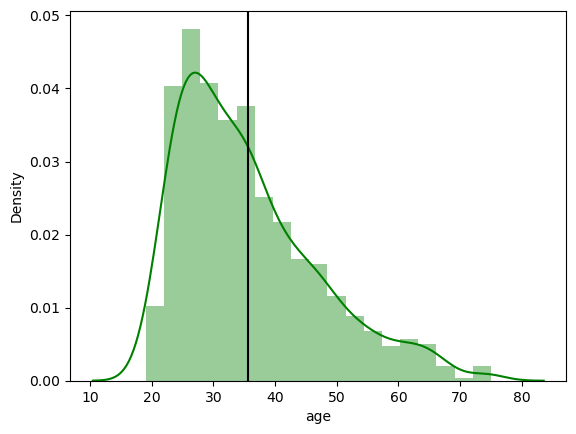

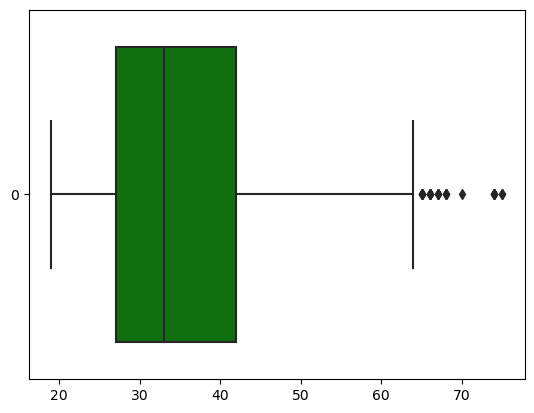

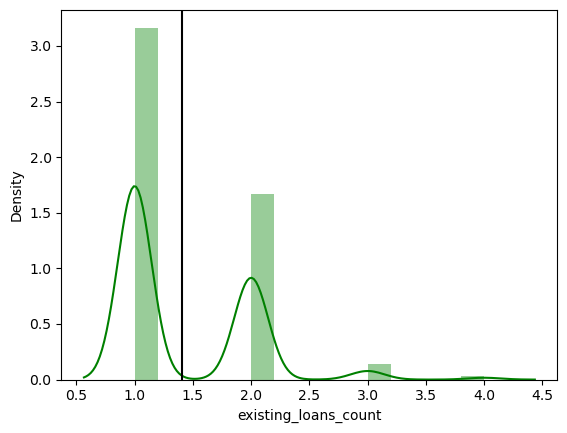

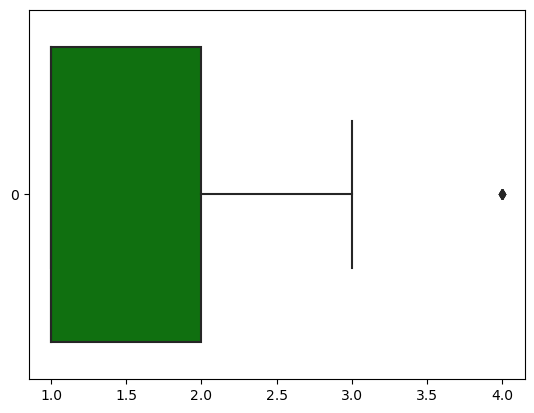

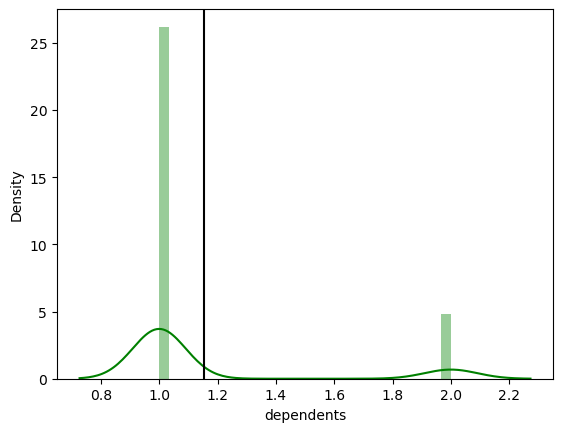

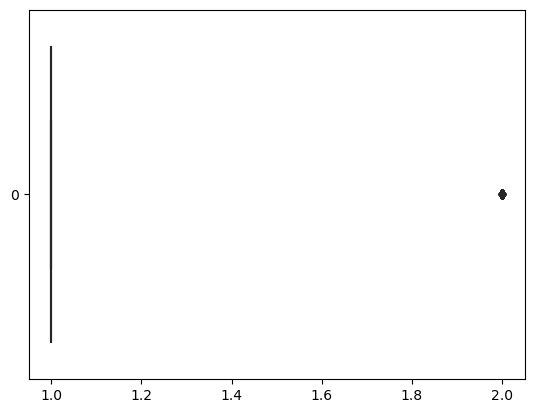

In [173]:
#fig, ax = plt.subplots(7, 1, figsize=(14/2.54, 12/2.54))  # create subplots
for col , d_type in data_german_bank.dtypes.items():
    if d_type == 'int64':
        sns.distplot(data_german_bank[col], color='g').axvline(data_german_bank[col].mean(), c='k')
        ## To save image to be used later in final report
        ## dpi to save good image resolution
        ## add bbox_inches='tight' to avoid cut off of axis labels
        plt.savefig(f"./submission/{col}_distplot.png", dpi=300, bbox_inches='tight')
        plt.show();
        #########################################################################################
        sns.boxplot(data_german_bank[col], orient='h', color='g')##.set_title(f' {col}')
        plt.savefig(f"./submission/{col}_boxplot.png", dpi=300, bbox_inches='tight')
        plt.show();
        

The box plots show that most of the credits amounts are between 1200 to 4000 dollars.


Most of the loan duration is from 11 to 25 months. Majority of the loan applicants have age between 28 - 42


All these continuos variables are positively skewed, And have outliers

##### Categorical Features

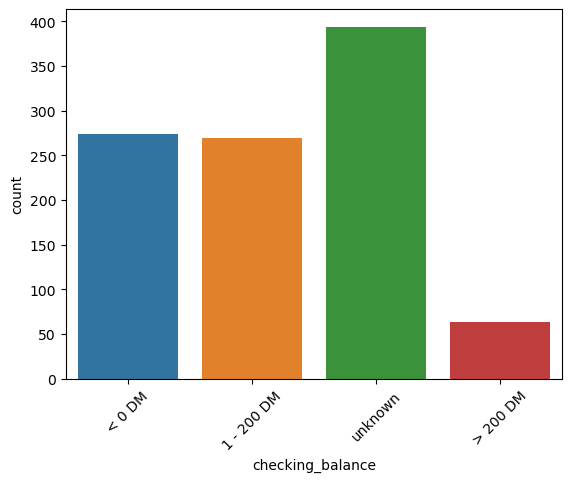

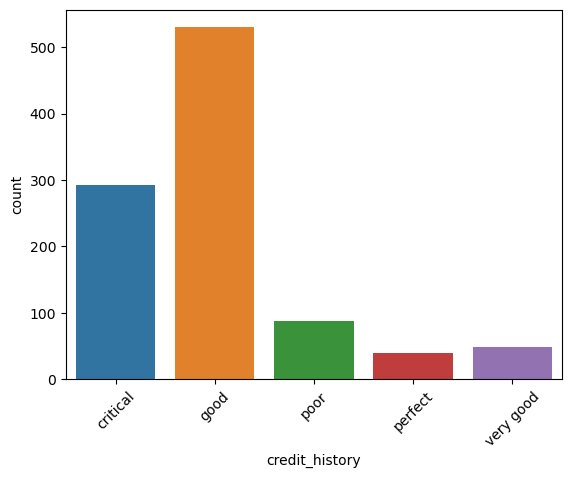

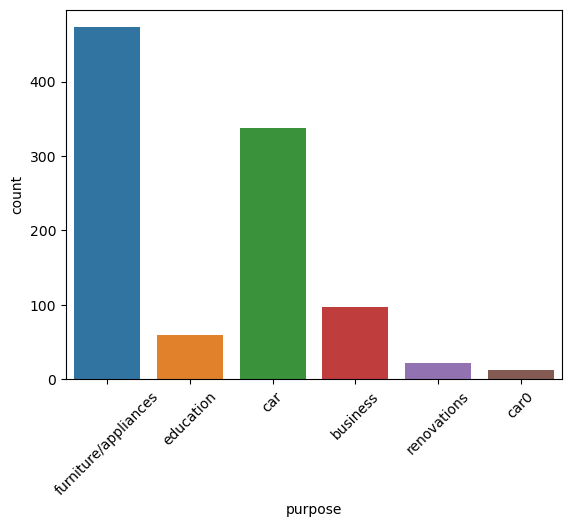

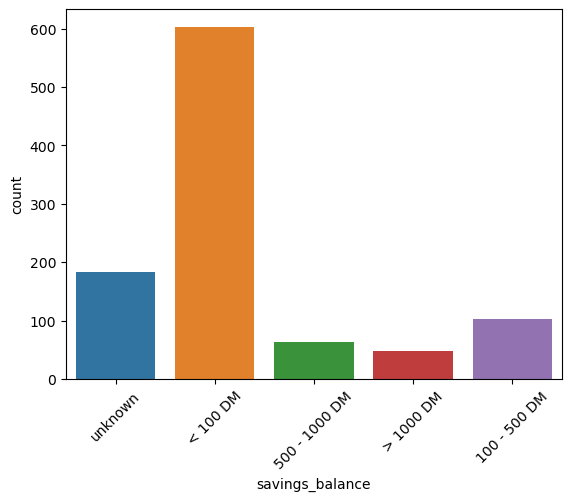

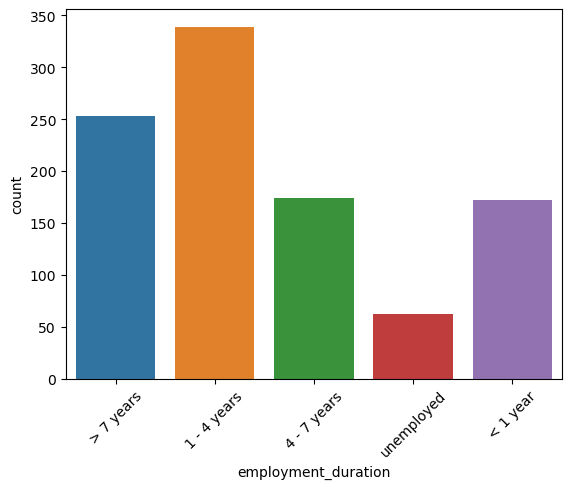

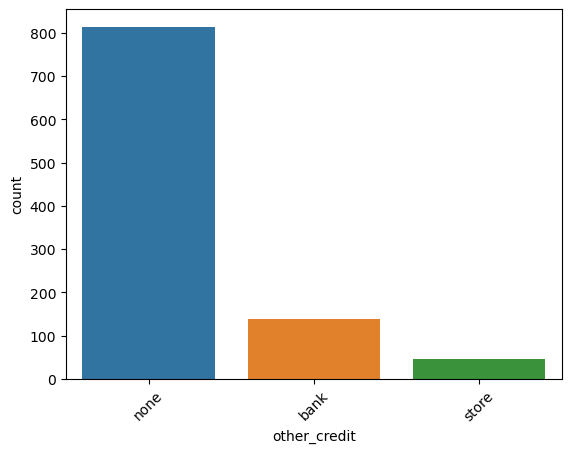

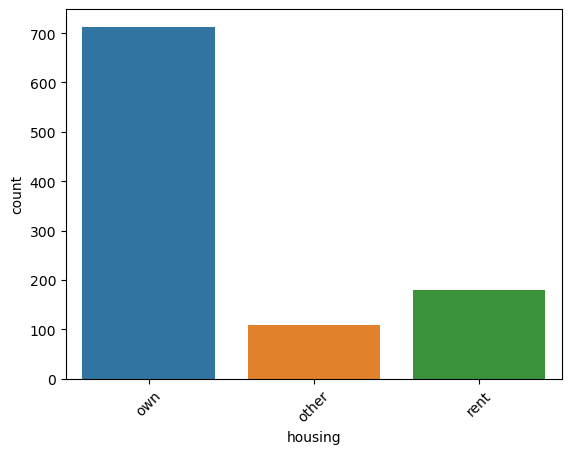

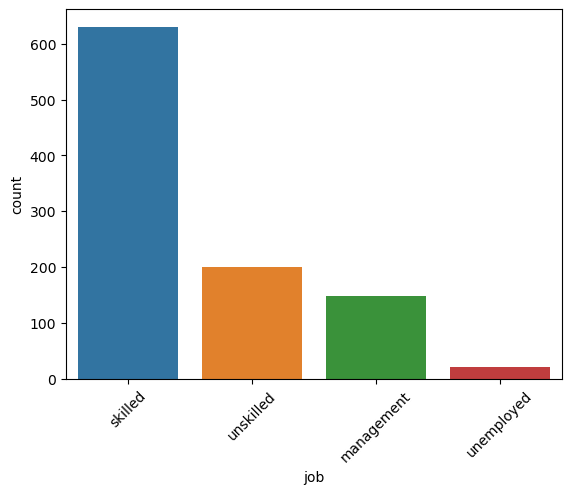

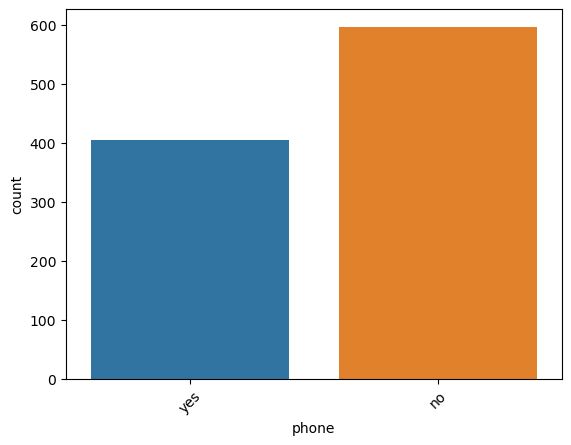

In [13]:
for col , d_type in data_german_bank.dtypes.items():
    if d_type == object:
        if col != 'default':
            sns.countplot(x=col, data=data_german_bank)
            plt.xticks(rotation=45)
            plt.show();

#### Bivariate Analysis

##### Categorical Features

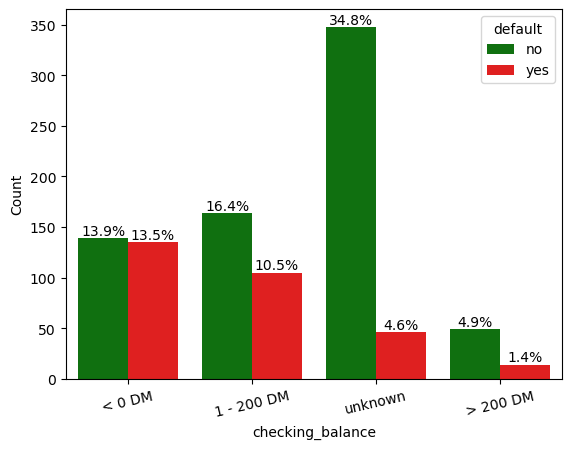

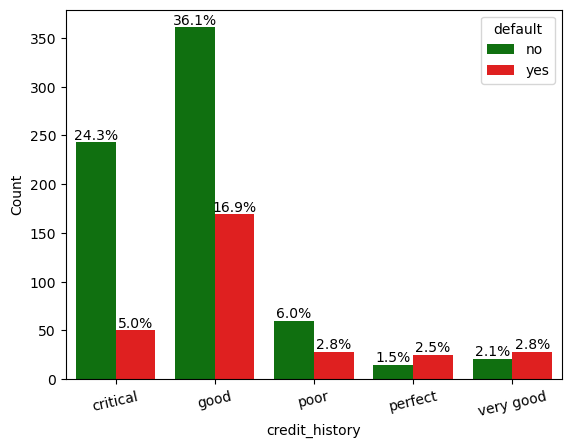

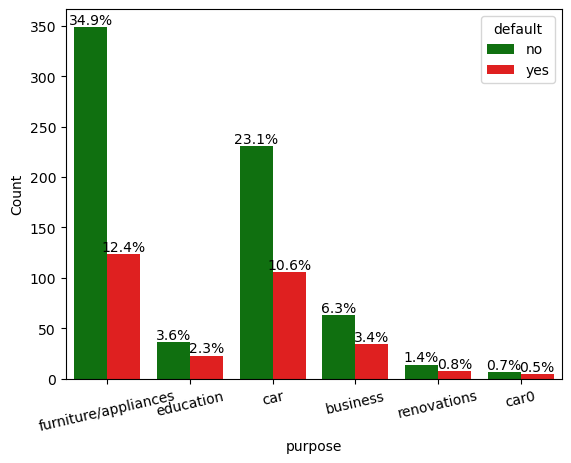

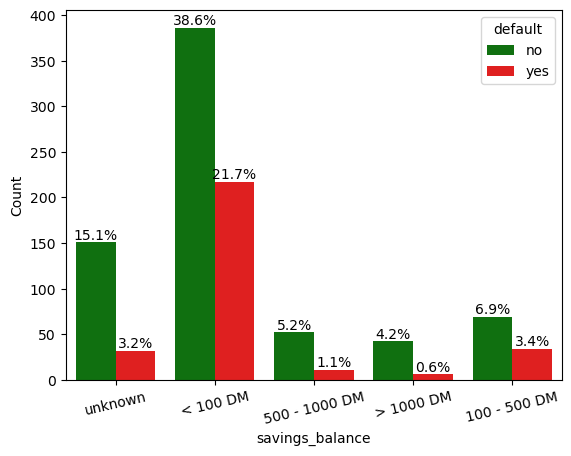

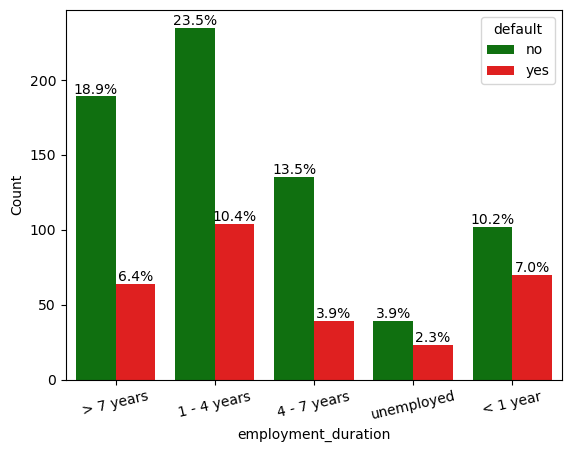

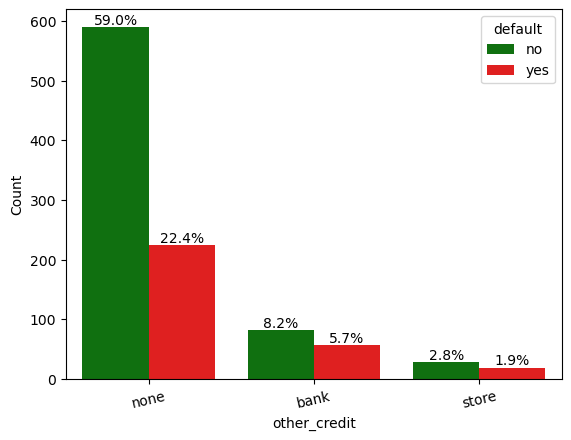

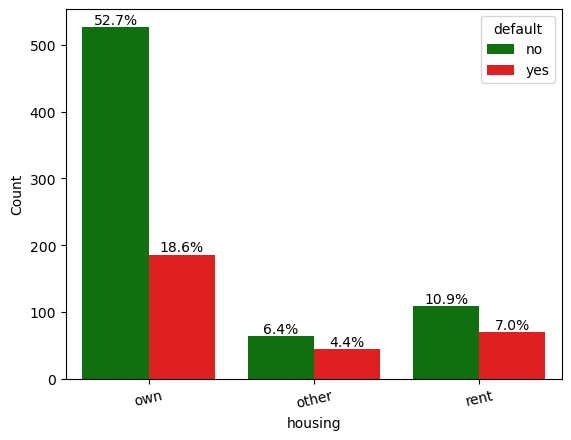

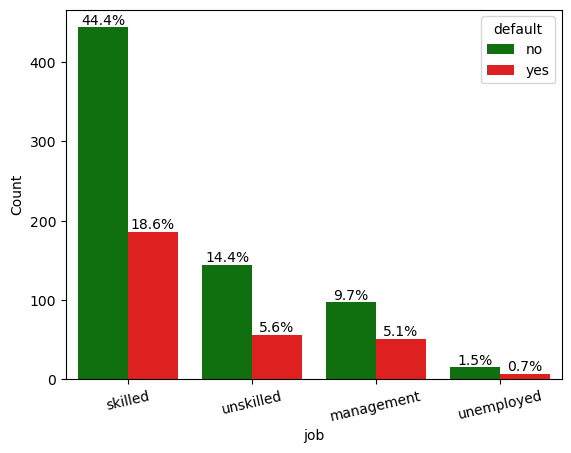

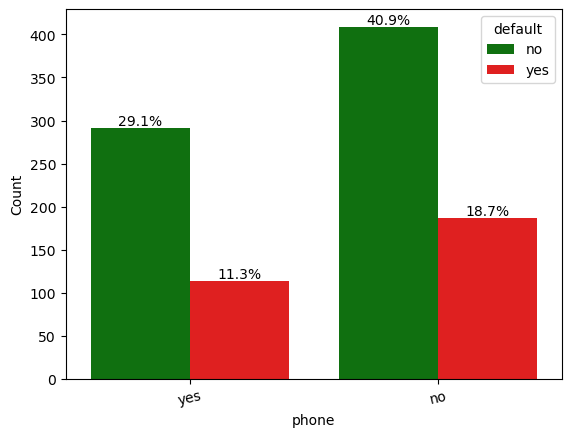

In [158]:
for col , d_type in data_german_bank.dtypes.items():
    if d_type == object:
        if col != 'default':
            ax = sns.countplot(x=col, hue="default", data=data_german_bank,palette=['g','r'])
            ax.set(ylabel='Count')#, title='Bar Count and Percent of Total')

            # add annotations
            for c in ax.containers:

                # custom label calculates percent and add an empty string so 0 value bars don't have a number
                labels = [f'{h/data_german_bank.default.count()*100:0.1f}%'\
                          if (h := v.get_height()) > 0 else '' for v in c]

                ax.bar_label(c, labels=labels, label_type='edge')
            plt.xticks(rotation=13)
            ## To save image to be used later in final report
            ## dpi to save good image resolution
            ## add bbox_inches='tight' to avoid cut off of axis labels
            plt.savefig(f"./submission/{col}_Bar_Count.png", dpi=300, bbox_inches='tight')
            plt.show();

checking balance has no observed link to default status, except for unknown class which have the lower probability of been defaulted. 


Suprisly, applicants with critical creadit history have lower probability of been default. 


Applicants with shorter employment duration tend to default more.

##### Numarical Features

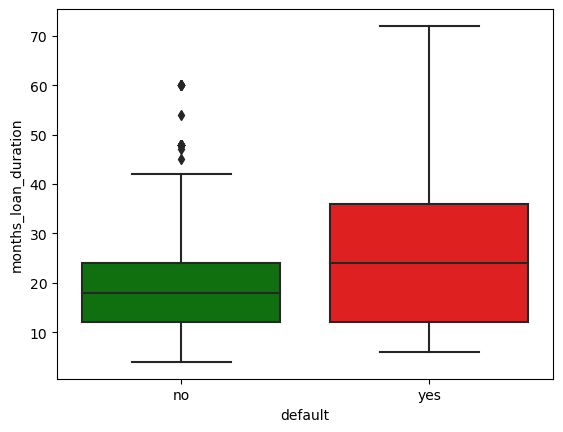

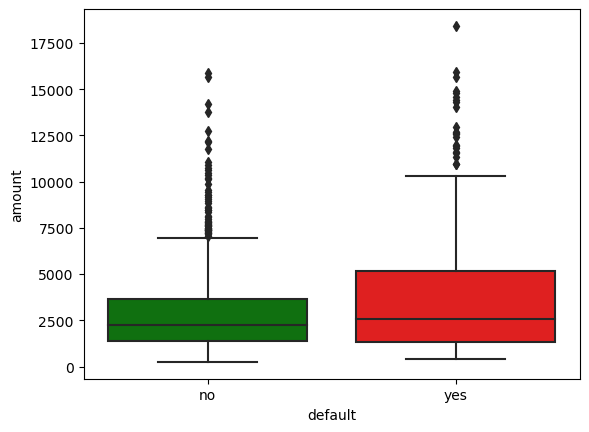

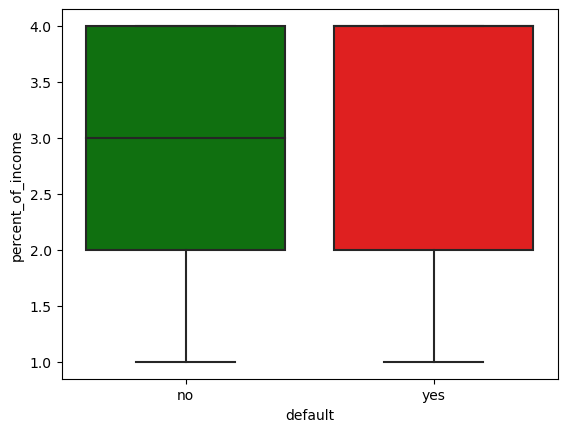

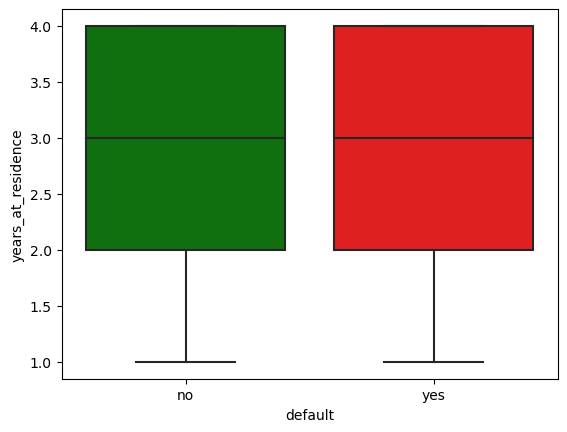

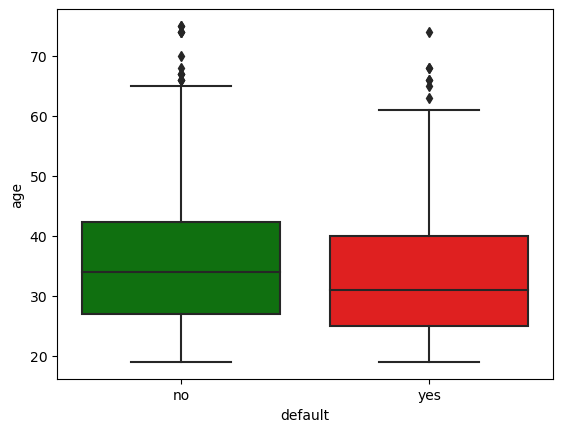

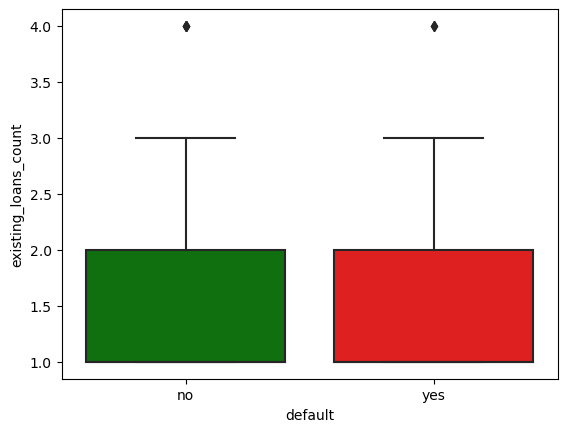

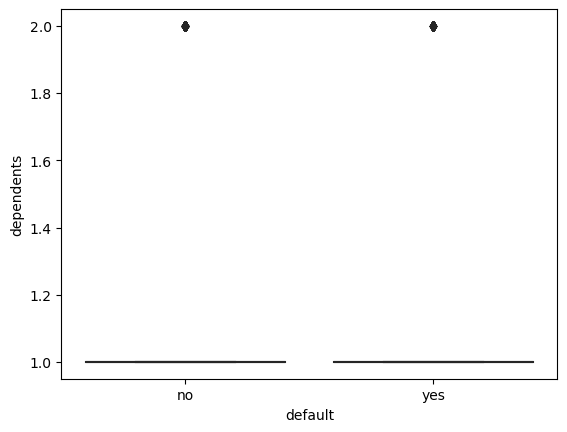

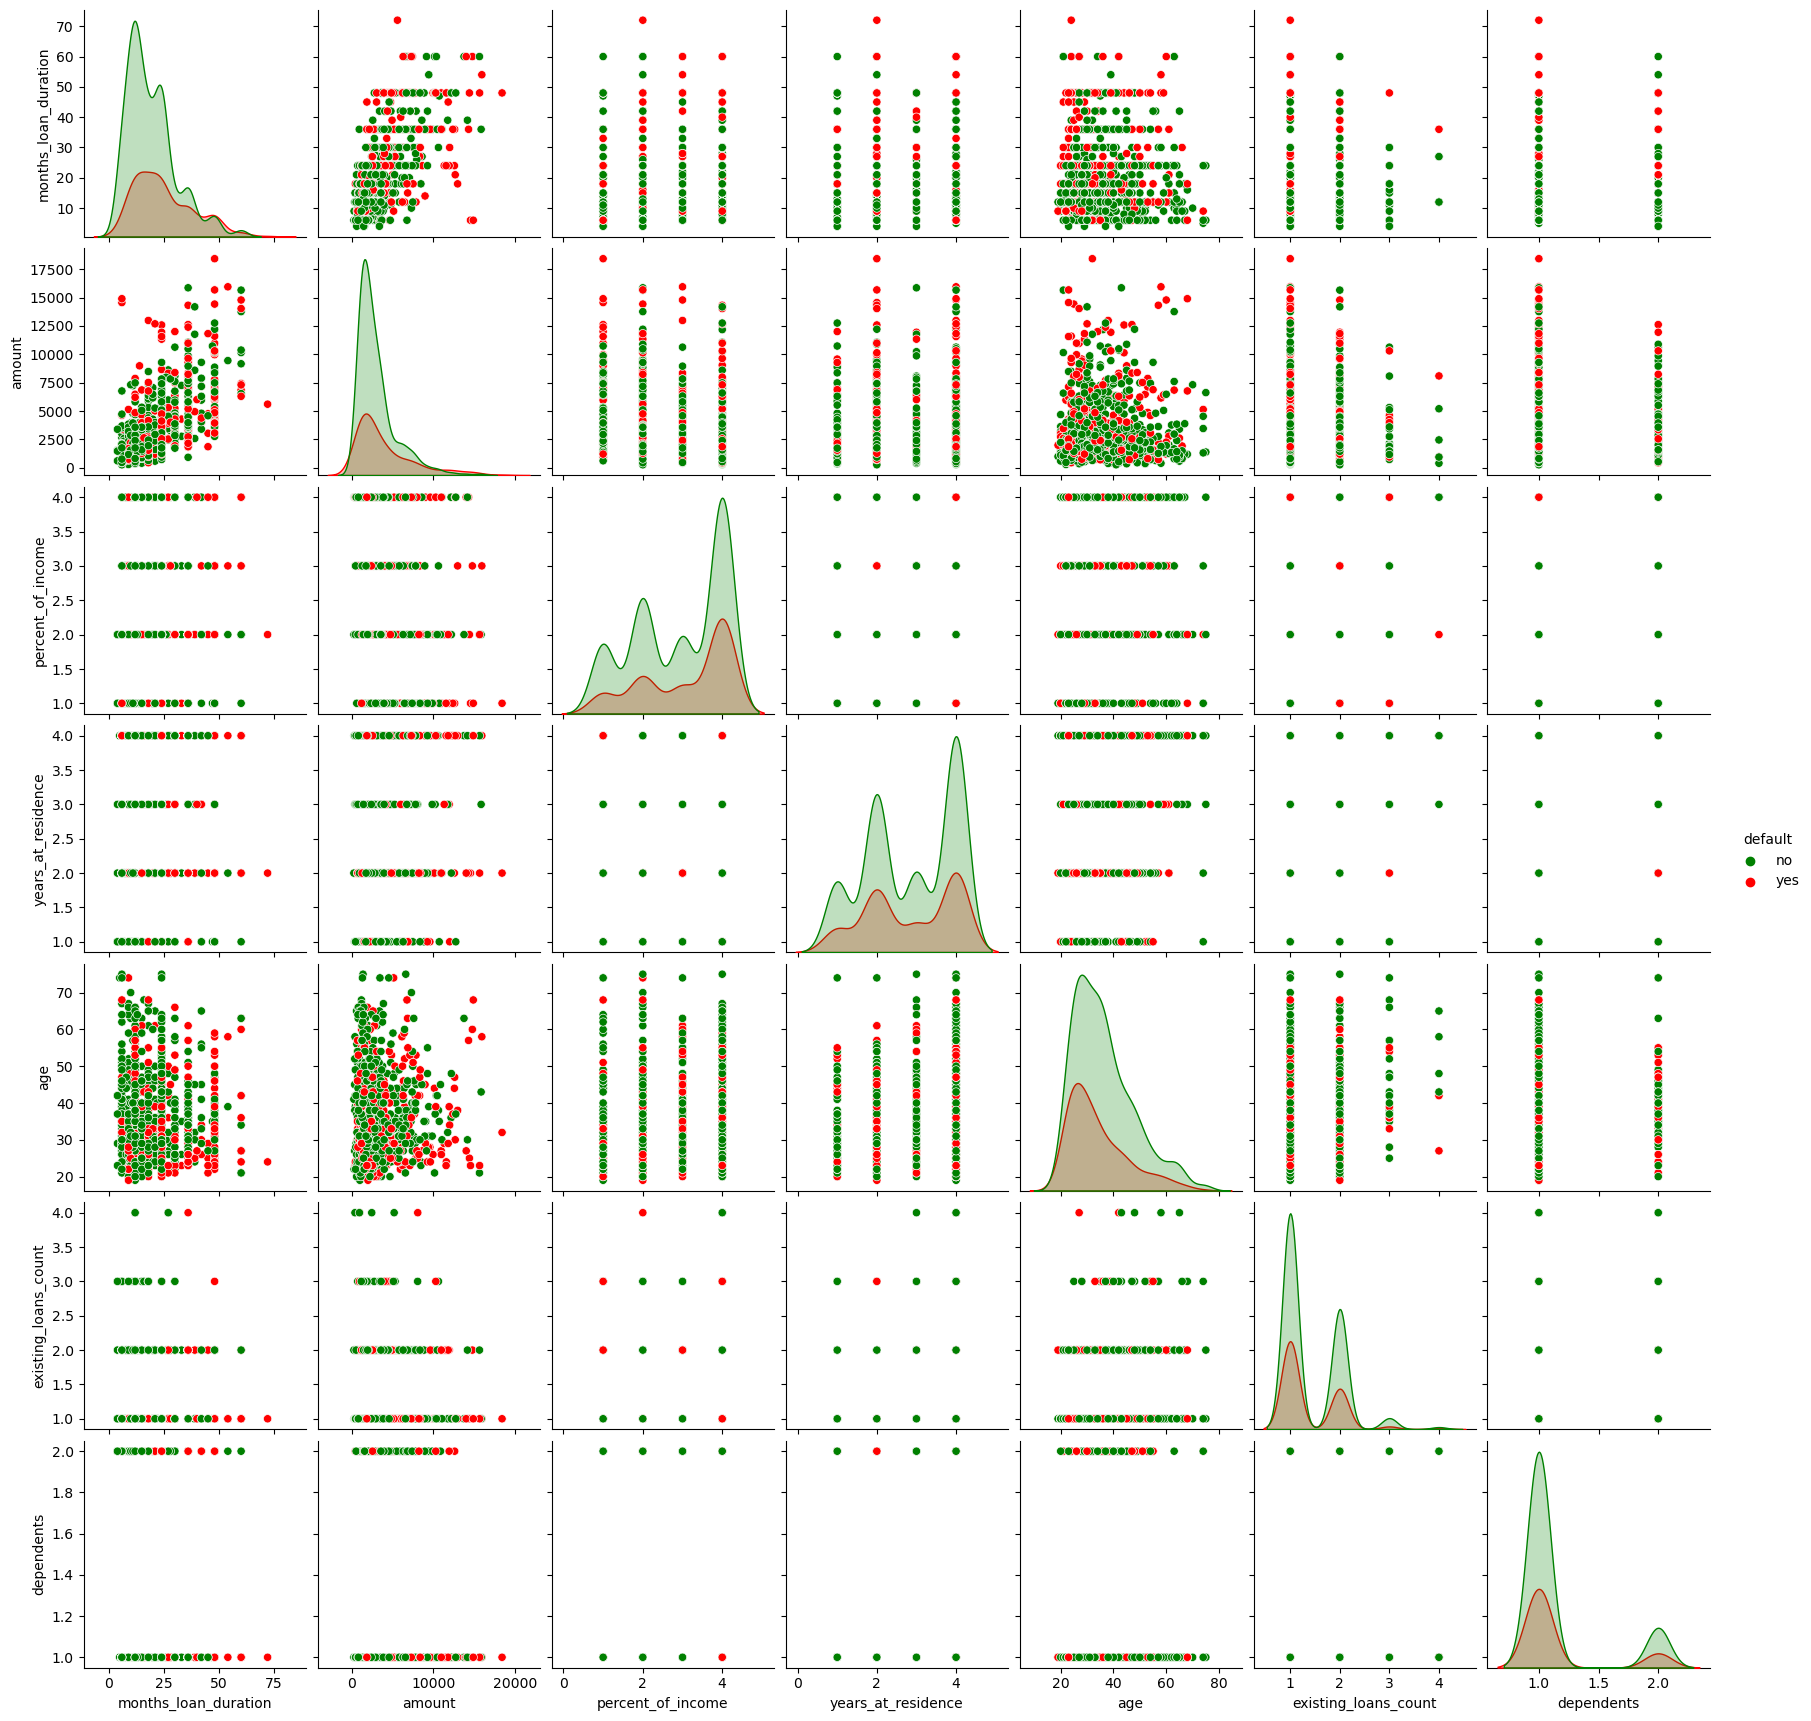

In [176]:
for col , d_type in data_german_bank.dtypes.items():
    if d_type == 'int64':
        sns.boxplot(data_german_bank, x='default', y=col , orient='v',
                    palette={'yes': 'red', 'no': 'g'})##.set_title(f'Boxplot - {col}')
        
        ## To save image to be used later in final report
        ## dpi to save good image resolution
        ## add bbox_inches='tight' to avoid cut off of axis labels
        plt.savefig(f"./submission/{col}_vs_target_boxplot", dpi=300, bbox_inches='tight')
        plt.show();



sns.pairplot(data_german_bank, hue='default', palette={'yes': 'red', 'no': 'g'})
plt.savefig(f"./submission/pairplot.png", dpi=300, bbox_inches='tight')
plt.show();



Duration of the loan has higher mean among those whom defaulted, with bigger range. 

Mean of loan amount is in close proximity among the default classes, same for years at residence.

Younger customers tend to default



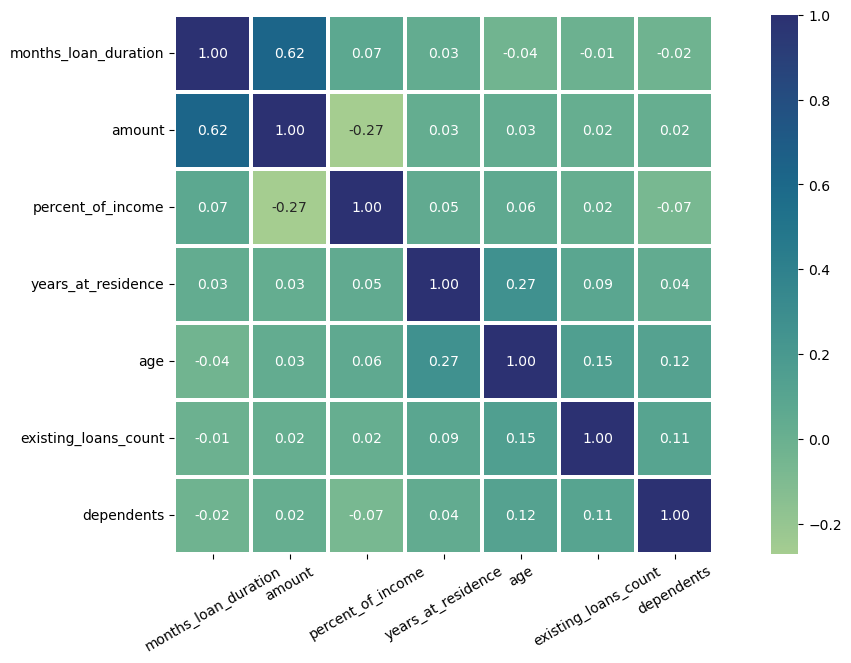

In [261]:
plt.figure(figsize=(15, 7))
sns.heatmap(data_german_bank.corr(numeric_only=True), annot=True, vmax=1,
            square=True ,fmt=".2f", cmap="crest" , linewidth=1.5)
plt.xticks(rotation=30)
plt.yticks(rotation=0)
## To save image to be used later in final report
## dpi to save good image resolution
## add bbox_inches='tight' to avoid cut off of axis labels
plt.savefig(f"./submission/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show();

# data_german_bank.corr(numeric_only=True)

Loan amount and duration have strong positive correlation, which is expected, also amount have weak negative correlation with percentage of income, and age have weak positive correlation with yeas at residence. There is no other significant correlation. 

### Data preparation

In [17]:
data_german_bank.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_duration', 'percent_of_income',
       'years_at_residence', 'age', 'other_credit', 'housing',
       'existing_loans_count', 'job', 'dependents', 'phone', 'default'],
      dtype='object')

In [18]:
'''First separate the target and transform it, 'yes' with 1, and 'no' with 0
Now we will have target with 1 (default) and 0 (doesn't default)'''

target = data_german_bank['default'].map({'yes':1, 'no':0})
target.sample(5)

41     0
511    0
529    0
306    0
474    1
Name: default, dtype: int64

In [19]:
'''For ordinal features (credit_history' , 'employment_duration) then keep this encoded columns into separate dataframe,
after encoding nominal features and scaling numerical we will join all three dataframe to form the predictors dataset'''

encoding=ColumnTransformer(transformers=[('oe',
                                          OrdinalEncoder(categories=[
                                              ['critical', 'poor', 'good', 'very good', 'perfect'],
                                              ['unemployed', '< 1 year', '1 - 4 years', '4 - 7 years', '> 7 years']]),
                                          ['credit_history' , 'employment_duration'])
                                        ])
encoding_ = encoding.fit_transform(data_german_bank)

ordinal_data = pd.DataFrame(encoding_,columns= ['credit_history' , 'employment_duration'])
ordinal_data

,credit_history,employment_duration
0,0.000,4.000
1,2.000,2.000
2,0.000,3.000
3,2.000,3.000
4,1.000,2.000
...,...,...
995,2.000,3.000
996,2.000,2.000
997,2.000,4.000
998,2.000,2.000


In [20]:
'''Transform nominal.
because get_dummies will use column values as part of dummy columns names, 
some columns will have names that hard to use later, will fix this here'''

nominal_col = ['checking_balance', 'purpose', 'savings_balance', 'other_credit', 'housing', 'job', 'phone']
nominal_data = pd.get_dummies(data_german_bank[nominal_col], drop_first=True,  dtype=int)

nominal_data.columns = nominal_data.columns.str.replace(' ','')
nominal_data.columns = nominal_data.columns.str.replace('>','greater')
nominal_data.columns = nominal_data.columns.str.replace('<','less')
nominal_data.columns = nominal_data.columns.str.replace('-','_')
nominal_data.columns = nominal_data.columns.str.replace('/','_')

nominal_data

,checking_balance_less0DM,checking_balance_greater200DM,checking_balance_unknown,purpose_car,purpose_car0,purpose_education,purpose_furniture_appliances,purpose_renovations,savings_balance_500_1000DM,savings_balance_less100DM,savings_balance_greater1000DM,savings_balance_unknown,other_credit_none,other_credit_store,housing_own,housing_rent,job_skilled,job_unemployed,job_unskilled,phone_yes
0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1
1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0
2,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0
996,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
997,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0
998,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1


In [21]:
'''Scaling numeric features'''

numaric_col = ['months_loan_duration', 'amount', 'percent_of_income', 
               'years_at_residence','age', 'existing_loans_count', 'dependents']
numeric_data = data_german_bank[numaric_col]
sc = StandardScaler()
numeric_data = sc.fit_transform(numeric_data)
numeric_data = pd.DataFrame(numeric_data, columns= numaric_col)
numeric_data

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
0,-1.236,-0.745,0.918,1.047,2.766,1.027,-0.428
1,2.248,0.950,-0.870,-0.766,-1.191,-0.705,-0.428
2,-0.739,-0.417,-0.870,0.141,1.183,-0.705,2.335
3,1.750,1.634,-0.870,1.047,0.832,-0.705,2.335
4,0.257,0.567,0.024,1.047,1.535,1.027,2.335
...,...,...,...,...,...,...,...
995,-0.739,-0.544,0.024,1.047,-0.400,-0.705,-0.428
996,0.755,0.208,0.918,1.047,0.392,-0.705,-0.428
997,-0.739,-0.875,0.918,1.047,0.216,-0.705,-0.428
998,1.999,-0.506,0.918,1.047,-1.103,-0.705,-0.428


In [22]:
'''Now joining all transformed features to form the predictors dataset'''

data = pd.concat([numeric_data, nominal_data, ordinal_data], axis=1)
data

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents,checking_balance_less0DM,checking_balance_greater200DM,checking_balance_unknown,purpose_car,purpose_car0,purpose_education,purpose_furniture_appliances,purpose_renovations,savings_balance_500_1000DM,savings_balance_less100DM,savings_balance_greater1000DM,savings_balance_unknown,other_credit_none,other_credit_store,housing_own,housing_rent,job_skilled,job_unemployed,job_unskilled,phone_yes,credit_history,employment_duration
0,-1.236,-0.745,0.918,1.047,2.766,1.027,-0.428,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,1,0.000,4.000
1,2.248,0.950,-0.870,-0.766,-1.191,-0.705,-0.428,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,2.000,2.000
2,-0.739,-0.417,-0.870,0.141,1.183,-0.705,2.335,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0.000,3.000
3,1.750,1.634,-0.870,1.047,0.832,-0.705,2.335,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,2.000,3.000
4,0.257,0.567,0.024,1.047,1.535,1.027,2.335,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1.000,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.739,-0.544,0.024,1.047,-0.400,-0.705,-0.428,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,2.000,3.000
996,0.755,0.208,0.918,1.047,0.392,-0.705,-0.428,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,2.000,2.000
997,-0.739,-0.875,0.918,1.047,0.216,-0.705,-0.428,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,2.000,4.000
998,1.999,-0.506,0.918,1.047,-1.103,-0.705,-0.428,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,2.000,2.000


In [23]:
data_german_bank

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,unknown,12,good,furniture/appliances,1736,< 100 DM,4 - 7 years,3,4,31,none,own,1,unskilled,1,no,no
996,< 0 DM,30,good,car,3857,< 100 DM,1 - 4 years,4,4,40,none,own,1,management,1,yes,no
997,unknown,12,good,furniture/appliances,804,< 100 DM,> 7 years,4,4,38,none,own,1,skilled,1,no,no
998,< 0 DM,45,good,furniture/appliances,1845,< 100 DM,1 - 4 years,4,4,23,none,other,1,skilled,1,yes,yes


In [24]:
'''split data and target into train test sets
Also we will split original data to fit CatBoostin
random state to make code reproducible
usig stratify for homogeneous subgroups (same proportion of classes in train and test sets as in original set  )'''
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state=1, stratify=target)


X = data_german_bank.drop(['default'], axis=1)
x_train_cat , x_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, target, test_size=0.3, random_state=1, stratify=target
)


In [25]:
print(x_train.shape, x_train_cat.shape, y_train.shape, y_train_cat.shape)

(700, 29) (700, 16) (700,) (700,)


In [26]:
print(x_test.shape, x_test_cat.shape, y_test.shape, y_test_cat.shape)

(300, 29) (300, 16) (300,) (300,)


In [27]:
y_test.value_counts(normalize=True)

default
0   0.700
1   0.300
Name: proportion, dtype: float64

## Model selection

### Base Models

In [28]:
 '''First will examing the models bellow with thier default settings
 using random state where possible to make code reproducible'''
# Appending models into the list
models = [] 
models.append(("LgR", LogisticRegression(random_state=1)))
models.append(("QDA", QuadraticDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("SVC", SVC(random_state=1)))
models.append(("RandomF", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("LightGBM", LGBMClassifier(random_state=1, verbose=-1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))  

In [263]:
'''Starting with cross validation


usig StratifiedKFold for homogeneous subgroups'''


models_compar_ = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision'])       
for name, model in models:
    scoring = "recall", "precision", "accuracy", "f1"
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1);

    cv_result = cross_validate( estimator=model, X=x_train, y=y_train,\
                               scoring=scoring, cv=kfold, return_train_score=True );
    
      
    model_train = pd.DataFrame({"Accuracy":(cv_result['train_accuracy'].mean()) ,\
                                "Recall": (cv_result['train_recall'].mean()),
                                "Precision": (cv_result['train_precision'].mean()),
                                "f1": (cv_result['train_f1'].mean() )},
                               index = [f"{name}_Train"])
    model_test = pd.DataFrame({"Accuracy":(cv_result['test_accuracy'].mean() ) ,\
                                "Recall": (cv_result['test_recall'].mean()),
                                "Precision": (cv_result['test_precision'].mean()),
                                "f1": (cv_result['test_f1'].mean() )},
                               index = [f"{name}_Test"])
    models_compar_ = pd.concat([models_compar_, model_train, model_test])
    


In [264]:
print("\n" "Cross-Validation Performance:" "\n")
models_compar_.T


Cross-Validation Performance:



,LgR_Train,LgR_Test,QDA_Train,QDA_Test,KNN_Train,KNN_Test,SVC_Train,SVC_Test,RandomF_Train,RandomF_Test,GBM_Train,GBM_Test,Adaboost_Train,Adaboost_Test,Xgboost_Train,Xgboost_Test,LightGBM_Train,LightGBM_Test,Bagging_Train,Bagging_Test
Accuracy,0.771,0.739,0.822,0.720,0.830,0.721,0.827,0.746,1.000,0.770,0.918,0.771,0.807,0.736,1.000,0.756,1.000,0.759,0.984,0.740
Recall,0.468,0.414,0.711,0.543,0.554,0.324,0.516,0.362,1.000,0.395,0.760,0.495,0.585,0.467,1.000,0.505,1.000,0.481,0.952,0.390
Precision,0.668,0.610,0.700,0.533,0.820,0.575,0.850,0.642,1.000,0.730,0.960,0.672,0.720,0.599,1.000,0.623,1.000,0.631,0.996,0.619
f1,0.550,0.488,0.705,0.536,0.661,0.410,0.641,0.456,1.000,0.506,0.848,0.564,0.645,0.510,1.000,0.554,1.000,0.544,0.973,0.471


In [265]:
%%time
scoring = "recall", "precision", "accuracy", "f1"
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1);
cat_features = ['checking_balance', 'credit_history', 'purpose', 'savings_balance',
                'employment_duration','other_credit', 'housing', 'job', 'phone']
cv_result = cross_validate( estimator=CatBoostClassifier(
    random_state=1, verbose=0,cat_features = cat_features), X=x_train_cat, y=y_train_cat,\
                           scoring=scoring, cv=kfold, return_train_score=True );


model_train = pd.DataFrame({"Accuracy":(cv_result['train_accuracy'].mean() ) ,\
                            "Recall": (cv_result['train_recall'].mean() ),
                            "Precision": (cv_result['train_precision'].mean() ),
                            "f1": (cv_result['train_f1'].mean() )},
                           index = ["Cat_Train"])
model_test = pd.DataFrame({"Accuracy":(cv_result['test_accuracy'].mean() ) ,\
                            "Recall": (cv_result['test_recall'].mean() ),
                            "Precision": (cv_result['test_precision'].mean()),
                            "f1": (cv_result['test_f1'].mean() )},
                           index = ["Cat_Test"])
models_compar_ = pd.concat([models_compar_, model_train, model_test])


CPU times: total: 2min 56s
Wall time: 4min 28s


In [266]:
models_compar_.T

,LgR_Train,LgR_Test,QDA_Train,QDA_Test,KNN_Train,KNN_Test,SVC_Train,SVC_Test,RandomF_Train,RandomF_Test,GBM_Train,GBM_Test,Adaboost_Train,Adaboost_Test,Xgboost_Train,Xgboost_Test,LightGBM_Train,LightGBM_Test,Bagging_Train,Bagging_Test,Cat_Train,Cat_Test
Accuracy,0.771,0.739,0.822,0.720,0.830,0.721,0.827,0.746,1.000,0.770,0.918,0.771,0.807,0.736,1.000,0.756,1.000,0.759,0.984,0.740,0.878,0.767
Recall,0.468,0.414,0.711,0.543,0.554,0.324,0.516,0.362,1.000,0.395,0.760,0.495,0.585,0.467,1.000,0.505,1.000,0.481,0.952,0.390,0.640,0.414
Precision,0.668,0.610,0.700,0.533,0.820,0.575,0.850,0.642,1.000,0.730,0.960,0.672,0.720,0.599,1.000,0.623,1.000,0.631,0.996,0.619,0.935,0.695
f1,0.550,0.488,0.705,0.536,0.661,0.410,0.641,0.456,1.000,0.506,0.848,0.564,0.645,0.510,1.000,0.554,1.000,0.544,0.973,0.471,0.759,0.515


In [267]:
base_model_compar_1 = models_compar_.T.iloc[:,:8]
base_model_compar_2 = models_compar_.T.iloc[:,8:16]
base_model_compar_3 = models_compar_.T.iloc[:,16:]

In [268]:
base_model_compar_1

,LgR_Train,LgR_Test,QDA_Train,QDA_Test,KNN_Train,KNN_Test,SVC_Train,SVC_Test
Accuracy,0.771,0.739,0.822,0.720,0.830,0.721,0.827,0.746
Recall,0.468,0.414,0.711,0.543,0.554,0.324,0.516,0.362
Precision,0.668,0.610,0.700,0.533,0.820,0.575,0.850,0.642
f1,0.550,0.488,0.705,0.536,0.661,0.410,0.641,0.456


In [269]:
base_model_compar_2

,RandomF_Train,RandomF_Test,GBM_Train,GBM_Test,Adaboost_Train,Adaboost_Test,Xgboost_Train,Xgboost_Test
Accuracy,1.000,0.770,0.918,0.771,0.807,0.736,1.000,0.756
Recall,1.000,0.395,0.760,0.495,0.585,0.467,1.000,0.505
Precision,1.000,0.730,0.960,0.672,0.720,0.599,1.000,0.623
f1,1.000,0.506,0.848,0.564,0.645,0.510,1.000,0.554


In [270]:
base_model_compar_3

,LightGBM_Train,LightGBM_Test,Bagging_Train,Bagging_Test,Cat_Train,Cat_Test
Accuracy,1.000,0.759,0.984,0.740,0.878,0.767
Recall,1.000,0.481,0.952,0.390,0.640,0.414
Precision,1.000,0.631,0.996,0.619,0.935,0.695
f1,1.000,0.544,0.973,0.471,0.759,0.515


Except for Logistic regression, all models are overfitting the train set. All of them have poor performance, especially the recall score that concerns us here.

To improve models performance, 

    - First we gonna tune them all and see how much improvemrnt we can get.
    - Also we can address the imbalance issue use some techniques like oversampling and weigh the classes by their representation in the data to reflect this imbalance.

In [273]:
os.getcwd()

'E:\\UoA\\03-Introduction to Machine Learning'

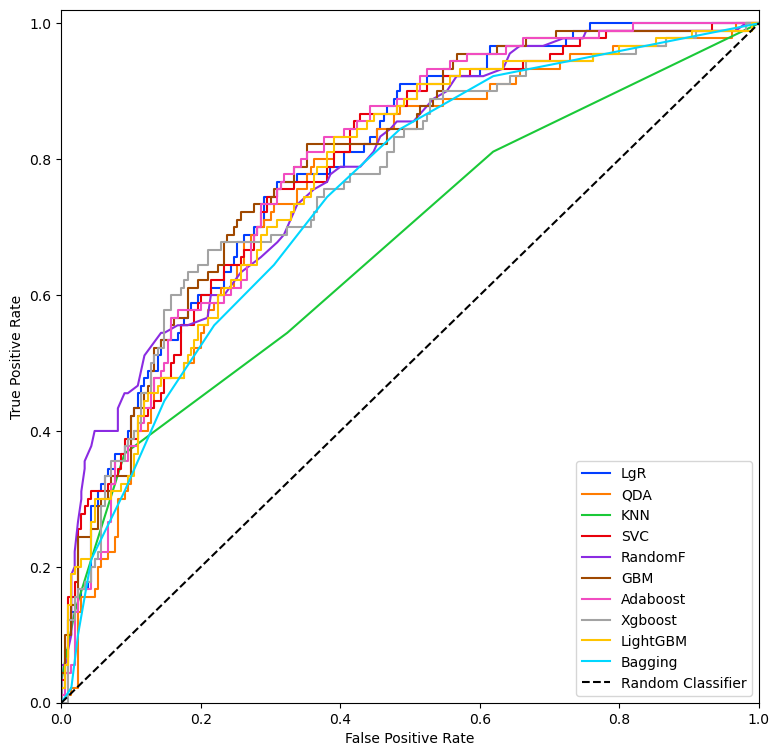

In [374]:

models_results, compar = classifiers_result_compar(models, x_train, y_train, x_test, y_test)
plot_ROC(models_results)


## To save image to be used later in final report
## dpi to save good image resolution
## add bbox_inches='tight' to avoid cut off of axis labels
plt.savefig(f"./submission/ROC_base_models", dpi=300, bbox_inches='tight')

### Tuning Models

In [38]:
tuned_models_compar_ = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision'])  

#### Logistic Regression

In [39]:
%%time
LgR_params = {
    'penalty':['l1', 'l2','elasticnet'],
    'C':np.logspace(-4, 4, 20), 
    'solver':['liblinear','sag', 'saga', 'lbfgs', 'newton-cg', 'newton-cholesky']
}

grid_cv = GridSearchCV(estimator=LogisticRegression(random_state=1, fit_intercept=True, class_weight='balanced') ,
                             param_grid=LgR_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" LgR :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
 LgR :
          Best Parameters= {'C': 0.012742749857031334, 'penalty': 'l1', 'solver': 'saga'}                    
          with CV recall = 0.7


CPU times: total: 1.41 s
Wall time: 11.4 s


In [40]:
tuned_LgR = fit_tunned_model(LogisticRegression(penalty=grid_cv.best_params_['penalty'],
                                    C= grid_cv.best_params_['C'], 
                                    solver=grid_cv.best_params_['solver'],
                                    random_state=1, fit_intercept=True, class_weight='balanced'),
                 'LgR')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_LgR])

In [41]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631


#### Quadratic Discriminant

In [42]:
%%time
QDA_params = {
    'reg_param': (0.00001, 0.00002, 0.000008,0.00003), 
    'store_covariance': (True, False),
    'tol': ( 0.0004,0.0003, 0.0002, 0.00015, 0.0001, 0.01), 
                   }
grid_cv = GridSearchCV(estimator=QuadraticDiscriminantAnalysis() ,
                             param_grid=QDA_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" QDA :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 48 candidates, totalling 480 fits
 QDA :
          Best Parameters= {'reg_param': 1e-05, 'store_covariance': True, 'tol': 0.0004}                    
          with CV recall = 0.5333333333333332


CPU times: total: 359 ms
Wall time: 1.01 s


In [43]:
tuned_QDA = fit_tunned_model(QuadraticDiscriminantAnalysis(
                                    reg_param=grid_cv.best_params_['reg_param'],
                                    store_covariance= grid_cv.best_params_['store_covariance'], 
                                    tol=grid_cv.best_params_['tol'],
                                    ),
                 'QDA')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_QDA])

In [44]:
tuned_models_compar_.T

,LgR train,LgR test,QDA train,QDA test
Accuracy,0.574,0.603,0.811,0.723
Recall,0.690,0.700,0.690,0.567
Precision,0.384,0.406,0.684,0.537
f1,0.493,0.514,0.687,0.551
zero_1_loss_,0.426,0.397,0.189,0.277
AUC,0.607,0.631,0.777,0.679


#### KNN Classifier

In [45]:
%%time
KNN_params = {
    'n_neighbors': list(range(3,20, 1)),
    'leaf_size': list(range(1,12,1)),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}


grid_cv = GridSearchCV(estimator=KNeighborsClassifier() ,
                             param_grid=KNN_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" KNN :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 1496 candidates, totalling 14960 fits
 KNN :
          Best Parameters= {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}                    
          with CV recall = 0.4238095238095238


CPU times: total: 15.9 s
Wall time: 1min 34s


In [46]:
tuned_KNN = fit_tunned_model(KNeighborsClassifier(
                                    weights=grid_cv.best_params_['weights'],
                                    metric= grid_cv.best_params_['metric'], 
                                    p=grid_cv.best_params_['p'],
                                    leaf_size=grid_cv.best_params_['leaf_size'],
                                    n_neighbors=grid_cv.best_params_['n_neighbors'],
                                    ),
                 'KNN')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_KNN])

In [47]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618


#### SVC

In [48]:
%%time
SVC_params = {
    'C': np.logspace(-4, 4, 20),
    'kernel': ('linear', 'poly', 'rbf'),
    'coef0': (0.0,  1.0),
    'shrinking': (True, False),
    
                   }


grid_cv = GridSearchCV(estimator=SVC(random_state=1) ,
                             param_grid=SVC_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" SVC :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
 SVC :
          Best Parameters= {'C': 545.5594781168514, 'coef0': 1.0, 'kernel': 'poly', 'shrinking': True}                    
          with CV recall = 0.5333333333333333


CPU times: total: 4.34 s
Wall time: 31min 43s


In [49]:
tuned_SVC = fit_tunned_model(SVC(random_state=1,
                                    shrinking=grid_cv.best_params_['shrinking'],
                                    kernel= grid_cv.best_params_['kernel'], 
                                    coef0=grid_cv.best_params_['coef0'],
                                    C=grid_cv.best_params_['C'],
                                    
                                    ),
                 'SVC')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_SVC])

In [50]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662


#### RF

In [51]:
%%time
RF_params = {
    'bootstrap': [True, False],
    'max_depth': [1,2,3,5],
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'min_samples_split': np.linspace(0.1, 1.0, 5),
    'n_estimators': list(range(1,101,10))
    }

grid_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=1) ,
                             param_grid=RF_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" RF :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
 RF :
          Best Parameters= {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 1}                    
          with CV recall = 0.019047619047619046


CPU times: total: 25.3 s
Wall time: 2min 59s


In [52]:
tuned_RF = fit_tunned_model(RandomForestClassifier(random_state=1,
                                        bootstrap=grid_cv.best_params_['bootstrap'],
                                        max_depth= grid_cv.best_params_['max_depth'], 
                                        
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        min_samples_split=grid_cv.best_params_['min_samples_split'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'RF')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_RF])

In [53]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


#### GB

In [54]:
%%time
GB_params = {
    'learning_rate' : [ 0.2, 0.3, 0.4],
    'max_depth': [1, 2, 3, 5, 6],
    'n_estimators': list(range(10,150,10)),
    'min_samples_leaf': np.linspace(0.01, 0.1, 6),
    'max_features': ['auto', 'sqrt',None],
}

grid_cv = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1) ,
                             param_grid=GB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" GB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 3780 candidates, totalling 37800 fits
 GB :
          Best Parameters= {'learning_rate': 0.2, 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 0.046000000000000006, 'n_estimators': 120}                    
          with CV recall = 0.5476190476190477


CPU times: total: 53.8 s
Wall time: 7min 30s


In [55]:
tuned_GB = fit_tunned_model(GradientBoostingClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        max_depth= grid_cv.best_params_['max_depth'], 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'GB')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_GB])

In [56]:
tuned_GB_1 = fit_tunned_model(GradientBoostingClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        max_depth= 1, 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 '1_GB')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_GB_1])

In [57]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


#### AdaBoost

In [58]:
%%time
AdaB_params = {'algorithm':['SAMME', 'SAMME.R'],
              'n_estimators': list(range(10,201,10)),
              'learning_rate' : [ 0.3, 0.2, 0.1, 0.05,0.03, 0.01],
              
              }

grid_cv = GridSearchCV(estimator=AdaBoostClassifier(random_state=1) ,
                             param_grid=AdaB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" AdaB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
 AdaB :
          Best Parameters= {'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 190}                    
          with CV recall = 0.4333333333333333


CPU times: total: 8.64 s
Wall time: 1min 14s


In [59]:
tuned_AdaB = fit_tunned_model(AdaBoostClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        algorithm= grid_cv.best_params_['algorithm'], 
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'AdaB')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_AdaB])

In [60]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


#### XGBClassifier

In [61]:
%%time
XGB_params = {   "learning_rate" : [ 0.3, 0.2, 0.1, 0.4],
     "eta"    : [0.40, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 1,2,3, 4, 5, 6],
     "min_child_weight" : [ 1, 3, 5 ],
     "gamma"            : [ 0.08, 0.1, 0.2 , 0.3 ],
     "colsample_bytree" : [ 0.6 , 0.7 ,0.8,0.9],
     "n_estimators"     : [ 30,40,50,100]
     }

grid_cv = GridSearchCV(estimator=XGBClassifier(random_state=1) ,
                             param_grid=XGB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" XGB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 18432 candidates, totalling 184320 fits
 XGB :
          Best Parameters= {'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.1, 'learning_rate': 0.4, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 50}                    
          with CV recall = 0.5571428571428572


CPU times: total: 5min 15s
Wall time: 19min 50s


In [62]:
tuned_XGB = fit_tunned_model(XGBClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        colsample_bytree= grid_cv.best_params_['colsample_bytree'], 
                                        eta=grid_cv.best_params_['eta'],
                                        gamma=grid_cv.best_params_['gamma'],
                                        max_depth=grid_cv.best_params_['max_depth'],
                                        min_child_weight=grid_cv.best_params_['min_child_weight'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                  
                                    ),
                 'XGB')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_XGB])

In [63]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


In [64]:
tuned_XGB = fit_tunned_model(XGBClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        colsample_bytree= grid_cv.best_params_['colsample_bytree'], 
                                        eta=grid_cv.best_params_['eta'],
                                        gamma=grid_cv.best_params_['gamma'],
                                        max_depth=4,
                                        min_child_weight=grid_cv.best_params_['min_child_weight'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                  
                                    ),
                 '1_XGB')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_XGB])

In [65]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


#### LightGB

In [66]:
%%time
Light_params = {   "learning_rate" : [ 0.3, 0.2, 0.1, 0.4],
     "boosting_type"    : ['gbdt', 'dart', 'rf' ],
     "max_depth"        : [ 1,2,3, 4, 5, 6],
     "min_child_weight" : [ 1, 3, 5 ],
     "colsample_bytree" : [ 0.6 , 0.7 ,0.8,0.9],
     "n_estimators"     : [ 30,40,50,100]
     }

grid_cv = GridSearchCV(estimator=LGBMClassifier(random_state=1, verbose=-1,n_jobs=-1,class_weight='balanced') ,
                             param_grid=Light_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" Light :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 3456 candidates, totalling 34560 fits
 Light :
          Best Parameters= {'boosting_type': 'rf', 'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 50}                    
          with CV recall = 0.8238095238095238


CPU times: total: 1min 4s
Wall time: 9min 36s


In [67]:
tuned_Light = fit_tunned_model(LGBMClassifier(random_state=1, verbose=-1,n_jobs=-1,class_weight='balanced',
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        colsample_bytree= grid_cv.best_params_['colsample_bytree'], 
                                        boosting_type=grid_cv.best_params_['boosting_type'],
                                        max_depth=grid_cv.best_params_['max_depth'],
                                        min_child_weight=grid_cv.best_params_['min_child_weight'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                  
                                    ),
                 'Light')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_Light])

In [68]:
tuned_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.574,0.690,0.384,0.493,0.426,0.607
LgR test,0.603,0.700,0.406,0.514,0.397,0.631
QDA train,0.811,0.690,0.684,0.687,0.189,0.777
QDA test,0.723,0.567,0.537,0.551,0.277,0.679
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.710,0.389,0.522,0.446,0.290,0.618
SVC train,1.000,1.000,1.000,1.000,0.000,1.000
SVC test,0.700,0.567,0.500,0.531,0.300,0.662
RF train,0.700,0.000,0.000,0.000,0.300,0.500
RF test,0.700,0.000,0.000,0.000,0.300,0.500


#### Baggin

In [69]:
%%time
Bagg_params = {
    'bootstrap': [True, False],
    'max_features': np.linspace(0.1, 1.0, 10),
    'n_estimators': list(range(10,300,10)),
    'warm_start': [True, False]
    }

grid_cv = GridSearchCV(estimator=BaggingClassifier(random_state=1, n_jobs=-1) ,
                             param_grid=Bagg_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(x_train, y_train)

print(f" Bagg :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 1160 candidates, totalling 11600 fits
 Bagg :
          Best Parameters= {'bootstrap': True, 'max_features': 1.0, 'n_estimators': 190, 'warm_start': True}                    
          with CV recall = 0.5380952380952382


CPU times: total: 40.8 s
Wall time: 13min 51s


In [70]:
tuned_Bagg = fit_tunned_model(BaggingClassifier(random_state=1, n_jobs=-1,
                                        bootstrap=grid_cv.best_params_['bootstrap'],
                                        max_features=grid_cv.best_params_['max_features'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                        warm_start=grid_cv.best_params_['warm_start'],
                                    ),
                 'Bagg')
tuned_models_compar_ = pd.concat([tuned_models_compar_, tuned_Bagg])

In [71]:
tuned_models_compar_.T

,LgR train,LgR test,QDA train,QDA test,KNN train,KNN test,SVC train,SVC test,RF train,RF test,GB train,GB test,1_GB train,1_GB test,AdaB train,AdaB test,XGB train,XGB test,1_XGB train,1_XGB test,Light train,Light test,Bagg train,Bagg test
Accuracy,0.574,0.603,0.811,0.723,1.000,0.710,1.000,0.700,0.700,0.700,0.997,0.747,0.786,0.750,0.801,0.740,0.979,0.750,0.946,0.750,0.580,0.653,1.000,0.733
Recall,0.690,0.700,0.690,0.567,1.000,0.389,1.000,0.567,0.000,0.000,0.995,0.544,0.462,0.433,0.529,0.467,0.938,0.489,0.857,0.533,0.824,0.900,1.000,0.433
Precision,0.384,0.406,0.684,0.537,1.000,0.522,1.000,0.500,0.000,0.000,0.995,0.583,0.724,0.619,0.735,0.583,0.990,0.603,0.957,0.593,0.402,0.460,1.000,0.574
f1,0.493,0.514,0.687,0.551,1.000,0.446,1.000,0.531,0.000,0.000,0.995,0.563,0.564,0.510,0.615,0.519,0.963,0.540,0.905,0.561,0.541,0.609,1.000,0.494
zero_1_loss_,0.426,0.397,0.189,0.277,0.000,0.290,0.000,0.300,0.300,0.300,0.003,0.253,0.214,0.250,0.199,0.260,0.021,0.250,0.054,0.250,0.420,0.347,0.000,0.267
AUC,0.607,0.631,0.777,0.679,1.000,0.618,1.000,0.662,0.500,0.500,0.997,0.689,0.693,0.660,0.723,0.662,0.967,0.675,0.920,0.688,0.650,0.724,1.000,0.648


### Addressing the Imbalance Issue

#### Oversampling 

In [72]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 1)
X_train, Y_train = smote.fit_resample(x_train, y_train)


In [73]:
Y_train.value_counts(normalize=True)

default
0   0.500
1   0.500
Name: proportion, dtype: float64

In [74]:
tuned_ovrsampl_models_compar_ = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision'])  

##### Logistic Regression

In [75]:
%%time
LgR_params = {
    'penalty':['l1', 'l2','elasticnet'],
    'C':np.logspace(-4, 4, 20), 
    'solver':['liblinear','sag', 'saga', 'lbfgs', 'newton-cg', 'newton-cholesky']
}

grid_cv = GridSearchCV(estimator=LogisticRegression(random_state=1, fit_intercept=True, class_weight='balanced') ,
                             param_grid=LgR_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" LgR :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
 LgR :
          Best Parameters= {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'sag'}                    
          with CV recall = 0.7897959183673471


CPU times: total: 1.59 s
Wall time: 9.68 s


In [76]:
tuned_LgR = fit_tunned_model_2(LogisticRegression(penalty=grid_cv.best_params_['penalty'],
                                    C= grid_cv.best_params_['C'], 
                                    solver=grid_cv.best_params_['solver'],
                                    random_state=1, fit_intercept=True, class_weight='balanced'),
                 'LgR')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_LgR])

In [77]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687


##### Quadratic Discriminant

In [78]:
%%time
QDA_params = {
    'reg_param': (0.00001, 0.00002, 0.000008,0.00003), 
    'store_covariance': (True, False),
    'tol': ( 0.0004,0.0003, 0.0002, 0.00015, 0.0001, 0.01), 
                   }
grid_cv = GridSearchCV(estimator=QuadraticDiscriminantAnalysis() ,
                             param_grid=QDA_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" QDA :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 48 candidates, totalling 480 fits
 QDA :
          Best Parameters= {'reg_param': 1e-05, 'store_covariance': True, 'tol': 0.0004}                    
          with CV recall = 0.8224489795918368


CPU times: total: 578 ms
Wall time: 1.08 s


In [79]:
tuned_QDA = fit_tunned_model_2(QuadraticDiscriminantAnalysis(
                                    reg_param=grid_cv.best_params_['reg_param'],
                                    store_covariance= grid_cv.best_params_['store_covariance'], 
                                    tol=grid_cv.best_params_['tol'],
                                    ),
                 'QDA')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_QDA])

In [80]:
tuned_ovrsampl_models_compar_.T

,LgR train,LgR test,QDA train,QDA test
Accuracy,0.787,0.703,0.796,0.697
Recall,0.804,0.644,0.861,0.678
Precision,0.777,0.504,0.762,0.496
f1,0.790,0.566,0.808,0.573
zero_1_loss_,0.213,0.297,0.204,0.303
AUC,0.787,0.687,0.796,0.691


##### KNN Classifier

In [81]:
%%time
KNN_params = {
    'n_neighbors': list(range(3,20, 1)),
    'leaf_size': list(range(1,12,1)),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}


grid_cv = GridSearchCV(estimator=KNeighborsClassifier() ,
                             param_grid=KNN_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" KNN :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 1496 candidates, totalling 14960 fits
 KNN :
          Best Parameters= {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}                    
          with CV recall = 0.9387755102040817


CPU times: total: 35.4 s
Wall time: 2min 8s


In [82]:
tuned_KNN = fit_tunned_model_2(KNeighborsClassifier(
                                    weights=grid_cv.best_params_['weights'],
                                    metric= grid_cv.best_params_['metric'], 
                                    p=grid_cv.best_params_['p'],
                                    leaf_size=grid_cv.best_params_['leaf_size'],
                                    n_neighbors=grid_cv.best_params_['n_neighbors'],
                                    ),
                 'KNN')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_KNN])

In [83]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640


##### SVC

In [84]:
%%time
SVC_params = {
    'C': np.logspace(-4, 4, 20),
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'coef0': (0.0, 10.0, 1.0),
    'shrinking': (True, False),
    
                   }


grid_cv = GridSearchCV(estimator=SVC(random_state=1) ,
                             param_grid=SVC_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" SVC :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 480 candidates, totalling 4800 fits
 SVC :
          Best Parameters= {'C': 0.03359818286283781, 'coef0': 0.0, 'kernel': 'poly', 'shrinking': True}                    
          with CV recall = 0.9081632653061226


CPU times: total: 14.2 s
Wall time: 1h 21min 49s


In [85]:
tuned_SVC = fit_tunned_model_2(SVC(random_state=1,
                                    shrinking=grid_cv.best_params_['shrinking'],
                                    kernel= grid_cv.best_params_['kernel'], 
                                    coef0=grid_cv.best_params_['coef0'],
                                    C=grid_cv.best_params_['C'],
                                    
                                    ),
                 'SVC')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_SVC])

In [86]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640


##### RF

In [87]:
%%time
RF_params = {
    'bootstrap': [True, False],
    'max_depth': [1,2, 3,  5, 6],
    'max_features': ['auto', 'sqrt',None],
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'min_samples_split': np.linspace(0.1, 1.0, 5),
    'n_estimators': list(range(1,100,5))
    }

grid_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=1) ,
                             param_grid=RF_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" RF :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 15000 candidates, totalling 150000 fits
 RF :
          Best Parameters= {'bootstrap': True, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.775, 'n_estimators': 6}                    
          with CV recall = 1.0


CPU times: total: 2min 52s
Wall time: 20min 41s


In [88]:
tuned_RF = fit_tunned_model_2(RandomForestClassifier(random_state=1,
                                        bootstrap=grid_cv.best_params_['bootstrap'],
                                        max_depth= grid_cv.best_params_['max_depth'], 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        min_samples_split=grid_cv.best_params_['min_samples_split'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'RF')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_RF])

In [89]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


In [90]:
fit_tunned_model_2(RandomForestClassifier(random_state=1,
                                        bootstrap=grid_cv.best_params_['bootstrap'],
                                        max_depth= 3, 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        min_samples_split=grid_cv.best_params_['min_samples_split'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'RF')
# tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_RF])

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


##### GB

In [91]:
%%time
GB_params = {
    'learning_rate' : [ 0.3, 0.2, 0.1, 0.05,0.4],
    'max_depth': [1,2, 3,  5, 6],
    'n_estimators': list(range(10,300,10)),
    'min_samples_leaf': np.linspace(0.01, 0.1, 10),
    'max_features': ['auto', 'sqrt',None],
}

grid_cv = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1) ,
                             param_grid=GB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" GB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 21750 candidates, totalling 217500 fits
 GB :
          Best Parameters= {'learning_rate': 0.1, 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 0.01, 'n_estimators': 10}                    
          with CV recall = 0.8795918367346939


CPU times: total: 10min 29s
Wall time: 1h 35min 12s


In [92]:
tuned_GB = fit_tunned_model_2(GradientBoostingClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        max_depth= grid_cv.best_params_['max_depth'], 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'GB')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_GB])

In [93]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


In [94]:
tuned_GB_1 = fit_tunned_model_2(GradientBoostingClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        max_depth= 1, 
                                        max_features=grid_cv.best_params_['max_features'],
                                        min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 '1_GB')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_GB_1])

In [95]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


##### AdaBoost

In [96]:
%%time
AdaB_params = {'algorithm':['SAMME', 'SAMME.R'],
              'n_estimators': list(range(10,201,10)),
              'learning_rate' : [ 0.3, 0.2, 0.1, 0.05,0.03, 0.01],
              
              }

grid_cv = GridSearchCV(estimator=AdaBoostClassifier(random_state=1) ,
                             param_grid=AdaB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" AdaB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
 AdaB :
          Best Parameters= {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 10}                    
          with CV recall = 0.8795918367346939


CPU times: total: 11.4 s
Wall time: 1min 29s


In [97]:
tuned_AdaB = fit_tunned_model_2(AdaBoostClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        algorithm= grid_cv.best_params_['algorithm'], 
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                    ),
                 'AdaB')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_AdaB])

In [98]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


##### XGBClassifier

In [99]:
%%time
XGB_params = {   "learning_rate" : [ 0.3, 0.2, 0.1, 0.4],
     "eta"    : [0.40, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 1,2,3, 4, 5, 6],
     "min_child_weight" : [ 1, 3, 5 ],
     "gamma"            : [ 0.08, 0.1, 0.2 , 0.3 ],
     "colsample_bytree" : [ 0.6 , 0.7 ,0.8,0.9],
     "n_estimators"     : [ 30,40,50,100]
     }

grid_cv = GridSearchCV(estimator=XGBClassifier(random_state=1) ,
                             param_grid=XGB_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" XGB :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 18432 candidates, totalling 184320 fits
 XGB :
          Best Parameters= {'colsample_bytree': 0.6, 'eta': 0.4, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 30}                    
          with CV recall = 0.8612244897959185


CPU times: total: 6min 32s
Wall time: 27min 47s


In [100]:
tuned_XGB = fit_tunned_model_2(XGBClassifier(random_state=1,
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        colsample_bytree= grid_cv.best_params_['colsample_bytree'], 
                                        eta=grid_cv.best_params_['eta'],
                                        gamma=grid_cv.best_params_['gamma'],
                                        max_depth=grid_cv.best_params_['max_depth'],
                                        min_child_weight=grid_cv.best_params_['min_child_weight'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                  
                                    ),
                 'XGB')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_XGB])

In [101]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


##### LightGB

In [102]:
%%time
Light_params = {   "learning_rate" : [ 0.3, 0.2, 0.1, 0.4],
     "boosting_type"    : ['gbdt', 'dart', 'rf' ],
     "max_depth"        : [ 1,2,3, 4, 5, 6],
     "min_child_weight" : [ 1, 3, 5 ],
     "colsample_bytree" : [ 0.6 , 0.7 ,0.8,0.9],
     "n_estimators"     : [ 30,40,50,100]
     }

grid_cv = GridSearchCV(estimator=LGBMClassifier(random_state=1, verbose=-1,n_jobs=-1,class_weight='balanced') ,
                             param_grid=Light_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" Light :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 3456 candidates, totalling 34560 fits
 Light :
          Best Parameters= {'boosting_type': 'rf', 'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 50}                    
          with CV recall = 0.8795918367346939


CPU times: total: 2min 32s
Wall time: 13min 27s


In [103]:
tuned_Light = fit_tunned_model_2(LGBMClassifier(random_state=1, verbose=-1,n_jobs=-1,class_weight='balanced',
                                        learning_rate=grid_cv.best_params_['learning_rate'],
                                        colsample_bytree= grid_cv.best_params_['colsample_bytree'], 
                                        boosting_type=grid_cv.best_params_['boosting_type'],
                                        max_depth=grid_cv.best_params_['max_depth'],
                                        min_child_weight=grid_cv.best_params_['min_child_weight'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                  
                                    ),
                 'Light')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_Light])

In [104]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


##### Baggin

In [105]:
%%time
Bagg_params = {
    'bootstrap': [True, False],
    'max_features': np.linspace(0.1, 1.0, 10),
    'n_estimators': list(range(10,300,10)),
    'warm_start': [True, False]
    }

grid_cv = GridSearchCV(estimator=BaggingClassifier(random_state=1,n_jobs=-1) ,
                             param_grid=Bagg_params, scoring="recall",
                            cv=10, verbose=2,  n_jobs = -1)

# Fitting parameters in GridSearchCV
grid_cv.fit(X_train, Y_train)

print(f" Bagg :\n{' '*10}Best Parameters= {grid_cv.best_params_}\
                    \n{' '*10}with CV recall = {grid_cv.best_score_}\n\n")


Fitting 10 folds for each of 1160 candidates, totalling 11600 fits
 Bagg :
          Best Parameters= {'bootstrap': True, 'max_features': 0.8, 'n_estimators': 260, 'warm_start': True}                    
          with CV recall = 0.8591836734693878


CPU times: total: 58.6 s
Wall time: 17min 48s


In [106]:
tuned_Bagg = fit_tunned_model_2(BaggingClassifier(random_state=1, n_jobs=-1,
                                        bootstrap=grid_cv.best_params_['bootstrap'],
                                        max_features=grid_cv.best_params_['max_features'],
                                        n_estimators=grid_cv.best_params_['n_estimators'],
                                        warm_start=grid_cv.best_params_['warm_start'],
                                    ),
                 'Bagg')
tuned_ovrsampl_models_compar_ = pd.concat([tuned_ovrsampl_models_compar_, tuned_Bagg])

In [107]:
tuned_ovrsampl_models_compar_

,Accuracy,Recall,Precision,f1,zero_1_loss_,AUC
LgR train,0.787,0.804,0.777,0.790,0.213,0.787
LgR test,0.703,0.644,0.504,0.566,0.297,0.687
QDA train,0.796,0.861,0.762,0.808,0.204,0.796
QDA test,0.697,0.678,0.496,0.573,0.303,0.691
KNN train,1.000,1.000,1.000,1.000,0.000,1.000
KNN test,0.687,0.522,0.480,0.500,0.313,0.640
SVC train,0.684,0.920,0.625,0.744,0.316,0.684
SVC test,0.540,0.889,0.385,0.537,0.460,0.640
RF train,0.500,1.000,0.500,0.667,0.500,0.500
RF test,0.300,1.000,0.300,0.462,0.700,0.500


In [278]:
tuned_ovrsampl = tuned_ovrsampl_models_compar_.drop(['zero_1_loss_','AUC'], axis=1).T

In [283]:
tuned = tuned_models_compar_.drop(['zero_1_loss_','AUC'], axis=1).T

### Best Models

In [403]:
best_models = []

best_models.append(("GBM", GradientBoostingClassifier(random_state= 1,
                                                    learning_rate= 0.1,
                                                    max_depth= 1, 
                                                    max_features= None,
                                                    min_samples_leaf= 0.01,
                                                    n_estimators= 10,)))

best_models.append(("Adaboost", AdaBoostClassifier(random_state=1,
                                               learning_rate= 0.1,
                                               algorithm= 'SAMME', 
                                               n_estimators= 10,)))

best_models.append(("LightGBM", LGBMClassifier(random_state=1, verbose=-1,n_jobs=-1,class_weight='balanced',
                                                learning_rate= 0.3,
                                                colsample_bytree= 0.6, 
                                                boosting_type= 'rf',
                                                max_depth= 1,
                                                min_child_weight=1,
                                                n_estimators=50,)))

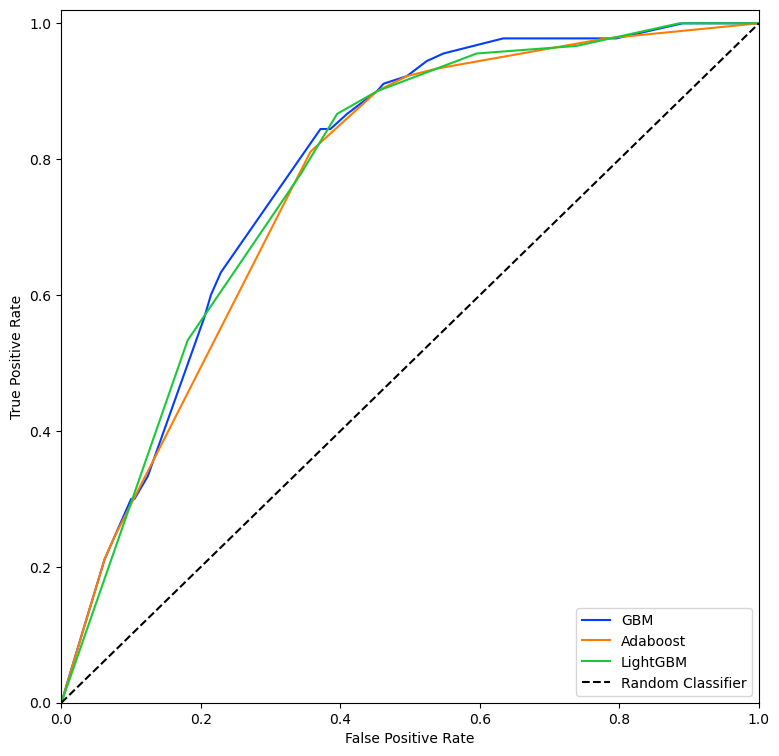

In [404]:
# classifiers_result_compar(models_, Xtrain, Ytrain, Xtest, Ytest)

best_models_results, best_compar = classifiers_result_compar(best_models, X_train, Y_train, x_test, y_test)
plot_ROC(best_models_results)
plt.savefig(f"./submission/ROC_best_models", dpi=300, bbox_inches='tight')

In [405]:
best_compar

,GBM train,GBM test,Adaboost train,Adaboost test,LightGBM train,LightGBM test
Accuracy,0.678,0.653,0.678,0.653,0.678,0.653
Recall,0.880,0.900,0.880,0.900,0.880,0.900
Precision,0.626,0.460,0.626,0.460,0.626,0.460
f1,0.732,0.609,0.732,0.609,0.732,0.609
zero_1_loss_,0.322,0.347,0.322,0.347,0.322,0.347
AUC,0.678,0.724,0.678,0.724,0.678,0.724


## Report

### Function

In [440]:
class PDFReport(FPDF):
    def Titel(self, font_size):
        self.set_font('Arial', 'B', font_size)
        self.cell(w=0, h=15, text='Prediction of Loan Default', border=0, ln=1, align='C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 3, ' {}'.format(self.page_no()), 0, 0, 'L')

    def section_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)
    
    def subsection_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(5)
        
    def table_image_title(self, title):
        self.set_font('Arial', 'B', 8)
        self.cell(0, 0, title, 0, 1, 'L')
#         self.ln(1)

    def body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 8, body)
        self.ln(1)
        
    def add_images(self, image_path):
        # Calculate center position
        page_width = self.w
        page_height = self.h 
        image_width = 100  # Adjust as needed
        image_height = 70  # Adjust as needed
        x = (page_width - image_width) / 3
        # Add image
        self.image(image_path, x, y=None, w=image_width, h=image_height)
        self.ln(0.3) 
 
    def add_3_images_in_line(self, images):
        x = self.get_x()  # Get current X position
        y = self.get_y()  # Get current Y position
        for image in images:
            image_hight = 60
            self.image(image, x, y, w=58, h=image_hight)  # Set width to 50 (adjust as needed)
            x += 68  # Move X position to the right by 60 units (adjust as needed)
        self.set_xy(x, y)  # Reset the position after adding images
        self.ln(image_hight+4)
        
    def add_4_images_in_line(self, images):
        x = self.get_x()  # Get current X position
        y = self.get_y()  # Get current Y position
        for image in images:
            image_hight = 60
            self.image(image, x, y, w=46, h=image_hight)  # Set width to 50 (adjust as needed)
            x += 50  # Move X position to the right by 60 units (adjust as needed)
        self.set_xy(x, y)  # Reset the position after adding images
        self.ln(image_hight+4)
        
    def add_table(self, header, data):
        # Calculate column widths based on A4 width
        page_width = self.w - 2*self.l_margin  # A4 width minus left and right margins
        num_cols = len(header)
        col_width = page_width / num_cols
        row_height = 10
        
        # Set table header style
        self.set_fill_color(230, 230, 230)
        self.set_font('Arial', 'B', 8)
        for item in header:
            self.cell(col_width, row_height, item, border=1, fill=True)
        self.ln(row_height)
        
        # Set table data style
        self.set_fill_color(255, 255, 255)
        self.set_font('Arial', '', 8)
        for row in data:
            for item in row:
                self.cell(col_width, row_height, str(item), border=1, fill=True)
            self.ln(row_height)
        self.ln(2)
        
    def add_dataframe(self, df):
        # Convert DataFrame to list of lists
        header = list(df.columns)
        data = df.values.tolist()
        # Add index to the header
        header.insert(0, 'Metrics')
        
        # Convert index to list and add to data
        index = df.index.tolist()
        for i in range(len(data)):
            data[i].insert(0, index[i])

        # Calculate column width based on A4 width
        col_width = self.w / len(header)
        
        # Add table
        self.add_table(header, data)
        self.ln(2) 
        
    def space(self,n):
        self.ln(n)


### Text

In [447]:
Introduction = "Financial institutions encounter a considerable challenge in predicting loan defaults."+\
" This poses an urgent dilemma for banks: identifying the customers most likly to defaulting on their loan"+\
" obligations. Given the significant implications for a bank's financial stability and strategic decisions,"+\
" accurately predicting defaults in the banking sector carries substantial importance.\n"+\
"The main objective of the project is to use dataset comprising historical data of customers who have availed bank loans,"+\
" to develop a predictive machine learning model capable of accurately forecasting a customer's probability"+\
" of default. This model leverages insights from diverse historical features associated with each"+\
" individual customer. In this context, we are try to answer the following questions:\n"+\
"Given the German bank dataset, which machine learning model predicts loan defaults the best?\n"+\
"In order to reduce false negatives and more accurately identify possible defaulters, how can we optimize"+\
" the performance of the model (recall)?\n"+\
"Does the chance of a loan default depend on financial related features? What about credit history,"+\
" as it may be a significant indicator of default risk?\n"


Methods_and_Materials = "Start with conducting exploratory data analysis aiming to have insight from the dataset,"+\
" first by looking at features data type and their values, no missing values are there,"+\
" although some categorical attributes have 'unknown', 'none' or 'unemployment' that makes"+\
" them nominal instead of ordinal, removing these categories could result in losing important information."+\
" There is also no redundancy in the dataset."+\
" Using graphs and statistics to study variables, then apply set of classification models and optimize their"+\
" performances to select best possible model. Moreover, addressing some issue with the dataset in hand like"+\
" imbalanced classes of the target.\n"
Exploratory_Data_Analysis = "Through visualization and statistical summaries, we gain clear understanding of features"+\
" and relationships between them. The target classes are imbalanced."


Exploratory_Data_Analysis_2 = "Continues variables (loan duration,"+\
" amount of the loan, and age) are positively skewed and have different range of their values, box plots show that"+\
" most of the amounts are between 1200 and 4000 dollars, most of the loan duration is from 11 to 25 months,"+\
" and majority of the loan applicants have age between 28 - 42(below figures).\n"


Exploratory_Data_Analysis_3 = "Also 'unknown' is the most frequent among checking"+\
" balance categories which have the lower probability of been defaulted."+\
" Surprisedly, applicants with critical credit history have"+\
" lower probability of been default. Also, Applicants with shorter employment duration tend to default more."





Exploratory_Data_Analysis_4 = "Duration of the loan has higher mean among those whom defaulted(yes),"+\
" with bigger range. Mean of loan"+\
" amount is in close proximity among the two default classes, same for years at residence,"+\
" and younger customers tend to default."


Exploratory_Data_Analysis_5 = "From correlation matrix, loan amount and duration have strong positive correlation,"+\
" which is expected,"+\
" also amount have weak negative correlation with percentage of income, and age have weak positive correlation"+\
" with yeas at residence. There is no other significant correlation.\n"





Results = "First, couple models were implemented with their default parameters. In term of overfitting,"+\
" the Logistic regression is the only model that does not overfit, especially when we focus on recall score."+\
" All test recall score are poor, ranging from Quadratic Discriminant with"+\
f" {base_model_compar_1.round(2).loc['Recall']['QDA_Test']} recall"+\
f" to the worse model K-nearest neighbours with {base_model_compar_1.round(2).loc['Recall']['KNN_Test']}."+\
" Three models had perfect fit on training data,"+\
" Random Forest, XGBoost, and Light Gradient Boosting."+\
f" Gradient Boosting has the highest test f1 score {base_model_compar_2.round(2).loc['f1']['GBM_Test']}."


Results_1 = "After tunning the important hyperparameters (below tables) still most models are overfitting,"+\
f" Logistic regression has improved in term of recall score now is {tuned.round(2).loc['Recall']['LgR test']} and"+\
" it's not overfitting but the"+\
" model and many other models test performance has overcome the performance on train set."+\
f" Light Gradient Boosting has the highest recall score of {tuned.round(2).loc['Recall']['Light test']},"+\
" and still K-nearest neighbours has the worst performance."

 

Results_2 = "Since the target is imbalanced, oversampling is performed to address this issue."+\
f" Random forest has the perfect recall score {tuned_ovrsampl.round(2).loc['Recall']['RF test']} but"+\
" with poor f1 score. Best performance is achieved by Gradient Boosting, AdaBoosting, and light boosting with"+\
f" {tuned_ovrsampl.round(2).loc['Recall']['GB test']} recall score on test set"+\
f" and {tuned_ovrsampl.round(2).loc['f1']['GB test']} f1."+\
f" Moreover, support vector machine has {tuned_ovrsampl.round(2).loc['Recall']['SVC test']} recall(below tables)."



Discussion = "From EDA we fund that there is no clear relationship between credit history and default status,"+\
" applicants with critical credit history have the lower probability among all categories."



Discussion_2 = "After oversampling the minority and tunning the models, these three model in the table below,"+\
" relatively has the best performance with the highest recall score on test set"+\
f" {best_compar.round(2).loc['Recall']['GBM test']}, and moderate"+\
f" f1 score {best_compar.round(2).loc['f1']['GBM test']},"+\
" but still there is some signs of overfitting since the f1 score difference between test and train sets is kind of"+\
f" big {round(best_compar.loc['f1']['GBM train'] - best_compar.loc['f1']['GBM test'],2)}."+\
" Furthermore, recall score for test is higher than on train, we have witnessed this behaviour along the analysis"+\
" of our models, it might be because of some difficult data points, this will lead us on discussing the limitations."


Discussion_3 = "Many issues have emerged during this study, starting with the relatively small dataset, which in some"+\
"situations cause overfitting, and in other cause test to overcome the training performance. Also in some predictors,"+\
" there were some unknown categories. Additionally, the target is imbalanced, even though applying oversampling still"+\
" this issue has it effect specially with the fact that the dataset is small."


Conclusions = "In conclusion, while our analysis sheds light on effective prediction models for identifying risky loan"+\
" applicants, it is essential to acknowledge the limitations inherent in our study. With the inclusion of more"+\
" extensive datasets encompassing a broader range of samples and features, and ongoing model development, financial"+\
" institutions can develop more robust prediction models to enhance their risk assessment processes and ultimately"+\
" improve profitability."

### Doc

In [449]:
pdf = PDFReport()
pdf.add_page()
pdf.Titel(16)
###########################################################################################################
###########################################################################################################
####### Introduction   ####################################################################################
pdf.section_title('Introduction')
pdf.body(Introduction)
###########################################################################################################
###########################################################################################################
####### Methods and Materials   ###########################################################################
pdf.section_title('Methods and Materials')
pdf.body(Methods_and_Materials)
###########################################################################
pdf.subsection_title('Exploratory Data Analysis')
pdf.body(Exploratory_Data_Analysis)

pdf.add_images('./submission/Percentage_of_defaulting_applicants.png')
###########################################################################
pdf.body(Exploratory_Data_Analysis_2)
images1 = ['./submission/months_loan_duration_distplot.png', './submission/amount_distplot.png', 
           './submission/age_distplot.png']
images2 = ['./submission/months_loan_duration_boxplot.png', './submission/amount_boxplot.png', 
           './submission/age_boxplot.png']
pdf.add_3_images_in_line(images1)
pdf.add_3_images_in_line(images2)
###########################################################################
pdf.body(Exploratory_Data_Analysis_3)
pdf.add_page()
images3 = ['./submission/checking_balance_Bar_Count.png', './submission/credit_history_Bar_Count.png', 
           './submission/employment_duration_Bar_Count.png']
pdf.add_3_images_in_line(images3)
###########################################################################
pdf.body(Exploratory_Data_Analysis_4)
images4 = ['./submission/months_loan_duration_vs_target_boxplot.png',   './submission/amount_vs_target_boxplot.png', 
           './submission/years_at_residence_vs_target_boxplot.png',   './submission/age_vs_target_boxplot.png' ]
pdf.add_4_images_in_line(images4)
###########################################################################
pdf.body(Exploratory_Data_Analysis_5)
pdf.add_images('./submission/correlation_matrix.png')
###########################################################################################################
###########################################################################################################
####### Results   #########################################################################################
pdf.add_page()
pdf.section_title('Results')
pdf.add_images('./submission/ROC_base_models.png')
pdf.body(Results)
pdf.space(8)
pdf.add_dataframe(base_model_compar_1.round(2))
pdf.space(8)
pdf.add_dataframe(base_model_compar_2.round(2))
pdf.add_page()
pdf.add_dataframe(base_model_compar_3.round(2))
#########################################################################################
pdf.body(Results_1)
pdf.space(8)
pdf.add_dataframe(tuned.iloc[:,:12].round(2))
pdf.space(8)
pdf.add_dataframe(tuned.iloc[:,12:].round(2))
pdf.space(8)
#########################################################################################
pdf.body(Results_2)
pdf.space(6)
pdf.add_dataframe(tuned_ovrsampl.iloc[:,:12].round(2))
pdf.space(4)
pdf.add_dataframe(tuned_ovrsampl.iloc[:,12:].round(2))
###########################################################################################################
###########################################################################################################
####### Discussion   ######################################################################################
pdf.space(2)
pdf.section_title('Discussion')
pdf.body(Discussion)
pdf.add_images('./submission/ROC_best_models.png')
pdf.space(2)
pdf.body(Discussion_2)
pdf.add_dataframe(best_compar.round(2))
pdf.space(8)
pdf.body(Discussion_3)
###########################################################################################################
###########################################################################################################
####### Conclusions   #####################################################################################
pdf.space(8)
pdf.section_title('Conclusions')
pdf.body(Conclusions)
###########################################################################################################
###########################################################################################################
pdf.output('./submission/final_report.pdf')


In [355]:
import dill
dill.dump_session('notebook_env.db')

In [354]:
dill.dump_session('notebook_env111.db')

In [ ]:
# dill.load_session('notebook_env.db')